# Optuna Tuning | XGBClassifier
**XGBoostClassifier** hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [12]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Machine learning
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [13]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

### 0.2 Constants

In [14]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'xgb' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

# Ensure the directories exist
os.makedirs(OPTUNA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(STUDY_PATH_NONE), exist_ok=True)

N_TRIALS = 100
RANDOM_STATE = 38

SCORE_NAME = 'F1-Score'
SCORING = make_scorer(fbeta_score, beta=1, average='macro')

### 0.3 Loading datasets

In [15]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [16]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [17]:
NUMERICAL_COLUMNS = [
    'age', 'time_in_hospital', 'num_medications',
    'num_emergency', 'num_inpatient', 'num_diagnoses'
]

In [18]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [19]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 45522, 1: 4523})
Test set: Counter({0: 19510, 1: 1938})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [20]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 20, step=2),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100)
    }
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = XGBClassifier(**params, random_state=RANDOM_STATE)
    
    # Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [21]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-01-05 16:31:57,840] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [22]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-05 16:32:02,336] Trial 3 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.053560080682006184, 'min_child_weight': 50}. Best is trial 3 with value: 0.47633597337075617.
[I 2025-01-05 16:32:02,484] Trial 6 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.03210110073249951, 'min_child_weight': 27}. Best is trial 3 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:04,433] Trial 8 finished with value: 0.47633597337075617 and parameters: {'max_depth': 8, 'learning_rate': 0.07089208822314515, 'min_child_weight': 93}. Best is trial 3 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:05,079] Trial 5 finished with value: 0.47633597337075617 and parameters: {'max_depth': 10, 'learning_rate': 0.0013049210809123076, 'min_child_weight': 93}. Best is trial 3 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:05,418] Trial 4 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'learning_rate': 0.006248380394730542, 'min_child_weight': 92}. Best is trial 3 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:05,623] Trial 9 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'learning_rate': 0.06912394731657825, 'min_child_weight': 98}. Best is trial 3 with value: 0.47633597337075617.
[I 2025-01-05 16:32:05,738] Trial 0 finished with value: 0.47633597337075617 and parameters: {'max_depth': 10, 'learning_rate': 0.07371954319876434, 'min_child_weight': 67}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:05,975] Trial 7 finished with value: 0.47633597337075617 and parameters: {'max_depth': 10, 'learning_rate': 0.0017788828540203424, 'min_child_weight': 51}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-05 16:32:06,020] Trial 12 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.0029350478342529255, 'min_child_weight': 76}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:06,861] Trial 2 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'learning_rate': 0.0025109773248963396, 'min_child_weight': 57}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:07,469] Trial 1 finished with value: 0.4763304938794345 and parameters: {'max_depth': 16, 'learning_rate': 0.08076281756094433, 'min_child_weight': 40}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47632501 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.4763304938794345


[I 2025-01-05 16:32:08,228] Trial 14 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.00486564838522714, 'min_child_weight': 95}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:08,903] Trial 10 finished with value: 0.4763250138147043 and parameters: {'max_depth': 20, 'learning_rate': 0.09185363983313886, 'min_child_weight': 34}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47632501 0.47635241 0.47632501 0.47632501 0.47629761]
Average score: 0.4763250138147043


[I 2025-01-05 16:32:10,261] Trial 11 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'learning_rate': 0.001224504091682578, 'min_child_weight': 15}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:10,731] Trial 13 finished with value: 0.47633597337075617 and parameters: {'max_depth': 10, 'learning_rate': 0.009875273208147592, 'min_child_weight': 31}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:13,145] Trial 18 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'learning_rate': 0.01204235068433104, 'min_child_weight': 77}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:13,593] Trial 21 finished with value: 0.47633597337075617 and parameters: {'max_depth': 8, 'learning_rate': 0.02343779906503726, 'min_child_weight': 65}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-05 16:32:13,735] Trial 17 finished with value: 0.47633597337075617 and parameters: {'max_depth': 16, 'learning_rate': 0.005462259018180147, 'min_child_weight': 85}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:14,032] Trial 15 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'learning_rate': 0.06433756252433241, 'min_child_weight': 89}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-05 16:32:14,120] Trial 19 finished with value: 0.47633597337075617 and parameters: {'max_depth': 14, 'learning_rate': 0.09318341519666792, 'min_child_weight': 94}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:15,055] Trial 16 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'learning_rate': 0.004519304863226819, 'min_child_weight': 43}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:15,583] Trial 22 finished with value: 0.47633597337075617 and parameters: {'max_depth': 12, 'learning_rate': 0.017970930444854337, 'min_child_weight': 63}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-05 16:32:15,658] Trial 24 finished with value: 0.47633597337075617 and parameters: {'max_depth': 8, 'learning_rate': 0.00880644526811744, 'min_child_weight': 59}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:16,397] Trial 26 finished with value: 0.47633597337075617 and parameters: {'max_depth': 6, 'learning_rate': 0.04215873641243772, 'min_child_weight': 74}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:17,217] Trial 23 finished with value: 0.47633597337075617 and parameters: {'max_depth': 14, 'learning_rate': 0.0365011999570678, 'min_child_weight': 66}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:18,424] Trial 20 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'learning_rate': 0.00311204578948165, 'min_child_weight': 11}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:19,500] Trial 29 finished with value: 0.47633597337075617 and parameters: {'max_depth': 6, 'learning_rate': 0.007594379176450973, 'min_child_weight': 70}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:20,343] Trial 32 finished with value: 0.47633597337075617 and parameters: {'max_depth': 6, 'learning_rate': 0.046340100215319674, 'min_child_weight': 46}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:21,175] Trial 25 finished with value: 0.47633597337075617 and parameters: {'max_depth': 12, 'learning_rate': 0.0022437033388938515, 'min_child_weight': 1}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:21,740] Trial 27 finished with value: 0.47633597337075617 and parameters: {'max_depth': 14, 'learning_rate': 0.014362276125059411, 'min_child_weight': 55}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:22,155] Trial 34 finished with value: 0.47633597337075617 and parameters: {'max_depth': 8, 'learning_rate': 0.053605036491102334, 'min_child_weight': 25}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:22,615] Trial 30 finished with value: 0.47633597337075617 and parameters: {'max_depth': 16, 'learning_rate': 0.0034062221465629605, 'min_child_weight': 82}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:22,962] Trial 36 finished with value: 0.47633597337075617 and parameters: {'max_depth': 6, 'learning_rate': 0.02664997599377069, 'min_child_weight': 47}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:23,271] Trial 31 finished with value: 0.47633597337075617 and parameters: {'max_depth': 12, 'learning_rate': 0.002068781659312508, 'min_child_weight': 53}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-05 16:32:23,415] Trial 28 finished with value: 0.47633597337075617 and parameters: {'max_depth': 16, 'learning_rate': 0.02131412836505847, 'min_child_weight': 42}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:23,758] Trial 38 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.0016390311689857366, 'min_child_weight': 61}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-05 16:32:23,889] Trial 33 finished with value: 0.47633597337075617 and parameters: {'max_depth': 10, 'learning_rate': 0.0311276213439787, 'min_child_weight': 36}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:25,502] Trial 35 finished with value: 0.47633597337075617 and parameters: {'max_depth': 14, 'learning_rate': 0.0010471005369722202, 'min_child_weight': 58}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:26,065] Trial 41 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.08280165103121784, 'min_child_weight': 35}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-05 16:32:26,121] Trial 37 finished with value: 0.47633597337075617 and parameters: {'max_depth': 10, 'learning_rate': 0.051896657567778816, 'min_child_weight': 70}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:28,850] Trial 39 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'learning_rate': 0.015820987159307045, 'min_child_weight': 50}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:30,216] Trial 43 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'learning_rate': 0.003763630117407884, 'min_child_weight': 98}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-05 16:32:30,353] Trial 44 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'learning_rate': 0.006323609597797291, 'min_child_weight': 90}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:30,433] Trial 40 finished with value: 0.47633597337075617 and parameters: {'max_depth': 12, 'learning_rate': 0.06429902717022233, 'min_child_weight': 23}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-05 16:32:30,492] Trial 42 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'learning_rate': 0.006164673290738658, 'min_child_weight': 82}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:31,002] Trial 47 finished with value: 0.47633597337075617 and parameters: {'max_depth': 8, 'learning_rate': 0.004348954129745901, 'min_child_weight': 55}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:31,724] Trial 46 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'learning_rate': 0.0024749223833295765, 'min_child_weight': 70}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:33,086] Trial 45 finished with value: 0.47633597337075617 and parameters: {'max_depth': 16, 'learning_rate': 0.001502233966656241, 'min_child_weight': 39}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:33,870] Trial 51 finished with value: 0.47633597337075617 and parameters: {'max_depth': 10, 'learning_rate': 0.0026108895532716324, 'min_child_weight': 88}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-05 16:32:34,051] Trial 49 finished with value: 0.47633597337075617 and parameters: {'max_depth': 16, 'learning_rate': 0.07354208301975908, 'min_child_weight': 79}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:34,739] Trial 48 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'learning_rate': 0.011797935613222692, 'min_child_weight': 30}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:36,499] Trial 52 finished with value: 0.47633597337075617 and parameters: {'max_depth': 10, 'learning_rate': 0.0013916881771893492, 'min_child_weight': 93}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:36,827] Trial 50 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'learning_rate': 0.09926505462213783, 'min_child_weight': 48}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-05 16:32:36,842] Trial 53 finished with value: 0.47633597337075617 and parameters: {'max_depth': 8, 'learning_rate': 0.001180432338992937, 'min_child_weight': 98}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:37,187] Trial 58 finished with value: 0.47633597337075617 and parameters: {'max_depth': 6, 'learning_rate': 0.003950783853632905, 'min_child_weight': 83}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:38,071] Trial 61 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.002107588561707762, 'min_child_weight': 79}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:38,348] Trial 56 finished with value: 0.47633597337075617 and parameters: {'max_depth': 20, 'learning_rate': 0.0029520083267527224, 'min_child_weight': 100}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:38,818] Trial 54 finished with value: 0.47633597337075617 and parameters: {'max_depth': 12, 'learning_rate': 0.0018411239806601233, 'min_child_weight': 86}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:39,044] Trial 55 finished with value: 0.47633597337075617 and parameters: {'max_depth': 14, 'learning_rate': 0.0010115903364245377, 'min_child_weight': 66}. Best is trial 0 with value: 0.47633597337075617.
[I 2025-01-05 16:32:39,135] Trial 57 finished with value: 0.47633597337075617 and parameters: {'max_depth': 12, 'learning_rate': 0.007587173476253465, 'min_child_weight': 76}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:40,060] Trial 62 finished with value: 0.47633597337075617 and parameters: {'max_depth': 6, 'learning_rate': 0.05345051527083644, 'min_child_weight': 16}. Best is trial 0 with value: 0.47633597337075617.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:40,809] Trial 63 finished with value: 0.4767817201281018 and parameters: {'max_depth': 4, 'learning_rate': 0.06466021084787335, 'min_child_weight': 1}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47745369 0.47742507]
Average score: 0.4767817201281018


[I 2025-01-05 16:32:41,058] Trial 59 finished with value: 0.47633597337075617 and parameters: {'max_depth': 10, 'learning_rate': 0.005192762157550343, 'min_child_weight': 91}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:42,219] Trial 67 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.010836188861909743, 'min_child_weight': 65}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:42,494] Trial 68 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.020266288004082617, 'min_child_weight': 6}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:43,019] Trial 66 finished with value: 0.47633597337075617 and parameters: {'max_depth': 6, 'learning_rate': 0.026987418254842716, 'min_child_weight': 31}. Best is trial 63 with value: 0.4767817201281018.
[I 2025-01-05 16:32:43,078] Trial 60 finished with value: 0.47633597337075617 and parameters: {'max_depth': 18, 'learning_rate': 0.03623375859769355, 'min_child_weight': 58}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:43,227] Trial 64 finished with value: 0.47633597337075617 and parameters: {'max_depth': 8, 'learning_rate': 0.03917025246631742, 'min_child_weight': 72}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:43,857] Trial 65 finished with value: 0.47633597337075617 and parameters: {'max_depth': 8, 'learning_rate': 0.03958383263989577, 'min_child_weight': 44}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:44,914] Trial 70 finished with value: 0.47633597337075617 and parameters: {'max_depth': 6, 'learning_rate': 0.08163871840560809, 'min_child_weight': 94}. Best is trial 63 with value: 0.4767817201281018.
[I 2025-01-05 16:32:45,021] Trial 73 finished with value: 0.4767817201281018 and parameters: {'max_depth': 4, 'learning_rate': 0.07289768255586185, 'min_child_weight': 2}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47745369 0.47742507]
Average score: 0.4767817201281018


[I 2025-01-05 16:32:45,263] Trial 74 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.04560775597634054, 'min_child_weight': 15}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:46,204] Trial 75 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.03143934445471379, 'min_child_weight': 19}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:46,989] Trial 71 finished with value: 0.47633597337075617 and parameters: {'max_depth': 10, 'learning_rate': 0.013469135209258914, 'min_child_weight': 52}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:47,193] Trial 77 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.04564044360497738, 'min_child_weight': 62}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:47,987] Trial 72 finished with value: 0.47633597337075617 and parameters: {'max_depth': 10, 'learning_rate': 0.0012902133001873558, 'min_child_weight': 38}. Best is trial 63 with value: 0.4767817201281018.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:48,350] Trial 76 finished with value: 0.4769964962621568 and parameters: {'max_depth': 6, 'learning_rate': 0.058541830638923834, 'min_child_weight': 5}. Best is trial 76 with value: 0.4769964962621568.


Cross validation scores: [0.47745369 0.47632501 0.47632501 0.47742507 0.47745369]
Average score: 0.4769964962621568


[I 2025-01-05 16:32:48,620] Trial 69 finished with value: 0.47656195243661104 and parameters: {'max_depth': 14, 'learning_rate': 0.06069397512249724, 'min_child_weight': 23}. Best is trial 76 with value: 0.4769964962621568.


Cross validation scores: [0.47748231 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47656195243661104


[I 2025-01-05 16:32:49,030] Trial 82 finished with value: 0.47677076057205003 and parameters: {'max_depth': 4, 'learning_rate': 0.09207229997703503, 'min_child_weight': 2}. Best is trial 76 with value: 0.4769964962621568.


Cross validation scores: [0.47629761 0.47635241 0.47632501 0.47745369 0.47742507]
Average score: 0.47677076057205003


[I 2025-01-05 16:32:49,282] Trial 83 finished with value: 0.47656170848745455 and parameters: {'max_depth': 4, 'learning_rate': 0.0698789777004486, 'min_child_weight': 10}. Best is trial 76 with value: 0.4769964962621568.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47745369]
Average score: 0.47656170848745455


[I 2025-01-05 16:32:50,018] Trial 81 finished with value: 0.47633597337075617 and parameters: {'max_depth': 6, 'learning_rate': 0.0684371130886577, 'min_child_weight': 96}. Best is trial 76 with value: 0.4769964962621568.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:50,641] Trial 80 finished with value: 0.47633597337075617 and parameters: {'max_depth': 8, 'learning_rate': 0.03227312057423034, 'min_child_weight': 12}. Best is trial 76 with value: 0.4769964962621568.
[I 2025-01-05 16:32:50,661] Trial 84 finished with value: 0.47656170848745455 and parameters: {'max_depth': 4, 'learning_rate': 0.05750693190745018, 'min_child_weight': 5}. Best is trial 76 with value: 0.4769964962621568.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47745369]
Average score: 0.47656170848745455


[I 2025-01-05 16:32:51,064] Trial 85 finished with value: 0.4767817201281018 and parameters: {'max_depth': 4, 'learning_rate': 0.049588490601920686, 'min_child_weight': 2}. Best is trial 76 with value: 0.4769964962621568.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47745369 0.47742507]
Average score: 0.4767817201281018


[I 2025-01-05 16:32:51,780] Trial 79 finished with value: 0.47633597337075617 and parameters: {'max_depth': 12, 'learning_rate': 0.0017961235060964433, 'min_child_weight': 55}. Best is trial 76 with value: 0.4769964962621568.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:52,002] Trial 87 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.06590386524458525, 'min_child_weight': 42}. Best is trial 76 with value: 0.4769964962621568.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:52,351] Trial 86 finished with value: 0.4765507489314027 and parameters: {'max_depth': 6, 'learning_rate': 0.07516601032126685, 'min_child_weight': 7}. Best is trial 76 with value: 0.4769964962621568.


Cross validation scores: [0.47632501 0.47635241 0.47632501 0.47629761 0.47745369]
Average score: 0.4765507489314027


[I 2025-01-05 16:32:52,954] Trial 90 finished with value: 0.47699625223998743 and parameters: {'max_depth': 4, 'learning_rate': 0.09267602203576632, 'min_child_weight': 2}. Best is trial 76 with value: 0.4769964962621568.


Cross validation scores: [0.47632501 0.47635241 0.47745369 0.47745369 0.47739646]
Average score: 0.47699625223998743


[I 2025-01-05 16:32:53,336] Trial 91 finished with value: 0.47656170848745455 and parameters: {'max_depth': 4, 'learning_rate': 0.060111699863410514, 'min_child_weight': 10}. Best is trial 76 with value: 0.4769964962621568.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47745369]
Average score: 0.47656170848745455


[I 2025-01-05 16:32:53,959] Trial 88 finished with value: 0.47633597337075617 and parameters: {'max_depth': 6, 'learning_rate': 0.008844003793484212, 'min_child_weight': 8}. Best is trial 76 with value: 0.4769964962621568.
[I 2025-01-05 16:32:54,071] Trial 92 finished with value: 0.47700769919395664 and parameters: {'max_depth': 4, 'learning_rate': 0.07496138153659632, 'min_child_weight': 4}. Best is trial 92 with value: 0.47700769919395664.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47748231 0.47635241 0.47632501 0.47745369 0.47742507]
Average score: 0.47700769919395664


[I 2025-01-05 16:32:54,511] Trial 78 finished with value: 0.4765455116689221 and parameters: {'max_depth': 20, 'learning_rate': 0.08455888988938888, 'min_child_weight': 27}. Best is trial 92 with value: 0.47700769919395664.
[I 2025-01-05 16:32:54,633] Trial 93 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.05773163828366541, 'min_child_weight': 12}. Best is trial 92 with value: 0.47700769919395664.
[I 2025-01-05 16:32:54,639] Trial 95 finished with value: 0.4767817201281018 and parameters: {'max_depth': 4, 'learning_rate': 0.05056213031820575, 'min_child_weight': 2}. Best is trial 92 with value: 0.47700769919395664.


Cross validation scores: [0.47748231 0.47635241 0.47629761 0.47632501 0.47627021]
Average score: 0.4765455116689221
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47745369 0.47742507]
Average score: 0.4767817201281018


[I 2025-01-05 16:32:55,245] Trial 96 finished with value: 0.47633597337075617 and parameters: {'max_depth': 4, 'learning_rate': 0.04873277675315179, 'min_child_weight': 9}. Best is trial 92 with value: 0.47700769919395664.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-05 16:32:55,756] Trial 99 finished with value: 0.47700769919395664 and parameters: {'max_depth': 4, 'learning_rate': 0.09009537925942275, 'min_child_weight': 4}. Best is trial 92 with value: 0.47700769919395664.


Cross validation scores: [0.47748231 0.47635241 0.47632501 0.47745369 0.47742507]
Average score: 0.47700769919395664


[I 2025-01-05 16:32:56,002] Trial 97 finished with value: 0.47805044732795465 and parameters: {'max_depth': 6, 'learning_rate': 0.09900284357011115, 'min_child_weight': 1}. Best is trial 97 with value: 0.47805044732795465.
[I 2025-01-05 16:32:56,133] Trial 98 finished with value: 0.47676527993382134 and parameters: {'max_depth': 6, 'learning_rate': 0.0749332856039392, 'min_child_weight': 7}. Best is trial 97 with value: 0.47805044732795465.


Cross validation scores: [0.47951762 0.47855011 0.47632501 0.47852028 0.47733922]
Average score: 0.47805044732795465
Cross validation scores: [0.47627021 0.47635241 0.47632501 0.47742507 0.47745369]
Average score: 0.47676527993382134


[I 2025-01-05 16:32:56,612] Trial 89 finished with value: 0.4763304938794345 and parameters: {'max_depth': 16, 'learning_rate': 0.059127828293076064, 'min_child_weight': 21}. Best is trial 97 with value: 0.47805044732795465.


Cross validation scores: [0.47632501 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.4763304938794345


[I 2025-01-05 16:32:56,935] Trial 94 finished with value: 0.482588705791855 and parameters: {'max_depth': 14, 'learning_rate': 0.086781255499527, 'min_child_weight': 5}. Best is trial 94 with value: 0.482588705791855.


Cross validation scores: [0.48271511 0.48469711 0.48601553 0.48024606 0.47926972]
Average score: 0.482588705791855


In [23]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 94
Best Parameters: {'max_depth': 14, 'learning_rate': 0.086781255499527, 'min_child_weight': 5}
Best Value: 0.482588705791855


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [24]:
optuna.visualization.plot_optimization_history(study)

In [25]:
optuna.visualization.plot_slice(study)

In [26]:
optuna.visualization.plot_param_importances(study)

In [27]:
optuna.visualization.plot_parallel_coordinate(study)

In [28]:
optuna.visualization.plot_contour(study)

In [29]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [30]:
# Fit best model on the training set
best_params = study.best_params

model = XGBClassifier(**best_params, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.086781255499527,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=38, ...)

In [31]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [32]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.9132380857228495
Test accuracy:  0.9083364416262588


In [33]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      1.00      0.95     19510
      Early-readmission       0.23      0.01      0.01      1938

               accuracy                           0.91     21448
              macro avg       0.57      0.50      0.48     21448
           weighted avg       0.85      0.91      0.87     21448



In [34]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

<Axes: >

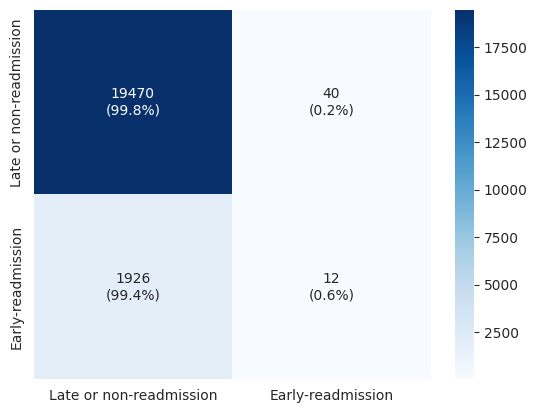

In [35]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [36]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 20, step=2),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        XGBClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [37]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-05 16:32:57,922] A new study created in Journal with name: Diabetes_130-US


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [38]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-05 16:33:01,170] Trial 7 finished with value: 0.5031286288754657 and parameters: {'max_depth': 4, 'learning_rate': 0.00727146959474903, 'min_child_weight': 85}. Best is trial 7 with value: 0.5031286288754657.


Cross validation scores: [0.50504945 0.50213595 0.51097703 0.49696439 0.50051632]
Average score: 0.5031286288754657


[I 2025-01-05 16:33:01,947] Trial 8 finished with value: 0.49285129050356646 and parameters: {'max_depth': 6, 'learning_rate': 0.003298137451161159, 'min_child_weight': 75}. Best is trial 7 with value: 0.5031286288754657.


Cross validation scores: [0.49378269 0.47785831 0.50977457 0.49597239 0.48686848]
Average score: 0.49285129050356646


[I 2025-01-05 16:33:02,488] Trial 2 finished with value: 0.4994573285182257 and parameters: {'max_depth': 6, 'learning_rate': 0.019792076120938293, 'min_child_weight': 1}. Best is trial 7 with value: 0.5031286288754657.


Cross validation scores: [0.49319138 0.49922448 0.51307919 0.505991   0.4858006 ]
Average score: 0.4994573285182257


[I 2025-01-05 16:33:02,968] Trial 5 finished with value: 0.4886704769034013 and parameters: {'max_depth': 8, 'learning_rate': 0.03808578497278645, 'min_child_weight': 83}. Best is trial 7 with value: 0.5031286288754657.
[I 2025-01-05 16:33:03,051] Trial 10 finished with value: 0.4859959534194359 and parameters: {'max_depth': 8, 'learning_rate': 0.05300005844804783, 'min_child_weight': 92}. Best is trial 7 with value: 0.5031286288754657.


Cross validation scores: [0.48627199 0.48424241 0.50090046 0.49444061 0.47749691]
Average score: 0.4886704769034013
Cross validation scores: [0.48477415 0.48583297 0.49583722 0.48877363 0.4747618 ]
Average score: 0.4859959534194359


[I 2025-01-05 16:33:03,206] Trial 9 finished with value: 0.4808556986285307 and parameters: {'max_depth': 16, 'learning_rate': 0.07881718883590991, 'min_child_weight': 96}. Best is trial 7 with value: 0.5031286288754657.


Cross validation scores: [0.47705299 0.48421694 0.4918343  0.47995133 0.47122293]
Average score: 0.4808556986285307


[I 2025-01-05 16:33:03,437] Trial 6 finished with value: 0.480656057368371 and parameters: {'max_depth': 10, 'learning_rate': 0.07569474115827328, 'min_child_weight': 58}. Best is trial 7 with value: 0.5031286288754657.
[I 2025-01-05 16:33:03,499] Trial 11 finished with value: 0.4913448234595076 and parameters: {'max_depth': 14, 'learning_rate': 0.0019836542121045224, 'min_child_weight': 68}. Best is trial 7 with value: 0.5031286288754657.


Cross validation scores: [0.47714497 0.48392737 0.49194105 0.47993119 0.4703357 ]
Average score: 0.480656057368371
Cross validation scores: [0.49573728 0.48005147 0.50216702 0.49597239 0.48279595]
Average score: 0.4913448234595076


[I 2025-01-05 16:33:03,943] Trial 4 finished with value: 0.4798724755010628 and parameters: {'max_depth': 14, 'learning_rate': 0.07138790191313643, 'min_child_weight': 58}. Best is trial 7 with value: 0.5031286288754657.
[I 2025-01-05 16:33:03,970] Trial 1 finished with value: 0.4877148250965761 and parameters: {'max_depth': 16, 'learning_rate': 0.013262449909837803, 'min_child_weight': 49}. Best is trial 7 with value: 0.5031286288754657.


Cross validation scores: [0.47478507 0.48469161 0.49224038 0.47889798 0.46874734]
Average score: 0.4798724755010628
Cross validation scores: [0.48294592 0.47424752 0.5036866  0.49588904 0.48180505]
Average score: 0.4877148250965761


[I 2025-01-05 16:33:04,469] Trial 0 finished with value: 0.47941571916603937 and parameters: {'max_depth': 18, 'learning_rate': 0.08321413405641871, 'min_child_weight': 54}. Best is trial 7 with value: 0.5031286288754657.


Cross validation scores: [0.47478051 0.48395543 0.48997616 0.47883903 0.46952746]
Average score: 0.47941571916603937


[I 2025-01-05 16:33:06,213] Trial 12 finished with value: 0.4839159836921819 and parameters: {'max_depth': 8, 'learning_rate': 0.07742263249579585, 'min_child_weight': 23}. Best is trial 7 with value: 0.5031286288754657.


Cross validation scores: [0.48102384 0.48693462 0.48839703 0.48819469 0.47502973]
Average score: 0.4839159836921819


[I 2025-01-05 16:33:06,753] Trial 16 finished with value: 0.49563580563540643 and parameters: {'max_depth': 4, 'learning_rate': 0.0020857512306983912, 'min_child_weight': 60}. Best is trial 7 with value: 0.5031286288754657.
[I 2025-01-05 16:33:06,819] Trial 3 finished with value: 0.4694803217681529 and parameters: {'max_depth': 18, 'learning_rate': 0.056458474635538165, 'min_child_weight': 15}. Best is trial 7 with value: 0.5031286288754657.


Cross validation scores: [0.50945778 0.49144905 0.52464062 0.47534594 0.47728564]
Average score: 0.49563580563540643
Cross validation scores: [0.4628393  0.47001047 0.47515393 0.47262844 0.46676947]
Average score: 0.4694803217681529


[I 2025-01-05 16:33:07,338] Trial 21 finished with value: 0.5058284130617051 and parameters: {'max_depth': 4, 'learning_rate': 0.02463466344797395, 'min_child_weight': 40}. Best is trial 21 with value: 0.5058284130617051.


Cross validation scores: [0.50311118 0.5063618  0.52088676 0.50431914 0.49446319]
Average score: 0.5058284130617051


[I 2025-01-05 16:33:07,568] Trial 13 finished with value: 0.4842077774255931 and parameters: {'max_depth': 12, 'learning_rate': 0.005856691822554939, 'min_child_weight': 50}. Best is trial 21 with value: 0.5058284130617051.
[I 2025-01-05 16:33:07,669] Trial 14 finished with value: 0.4892018913374697 and parameters: {'max_depth': 8, 'learning_rate': 0.001301316448450134, 'min_child_weight': 65}. Best is trial 21 with value: 0.5058284130617051.


Cross validation scores: [0.47914502 0.474483   0.49847762 0.49346618 0.47546708]
Average score: 0.4842077774255931
Cross validation scores: [0.49548455 0.48177764 0.49262093 0.49597239 0.48015395]
Average score: 0.4892018913374697


[I 2025-01-05 16:33:08,382] Trial 19 finished with value: 0.48876513452613357 and parameters: {'max_depth': 16, 'learning_rate': 0.003672308616209161, 'min_child_weight': 78}. Best is trial 21 with value: 0.5058284130617051.


Cross validation scores: [0.49371128 0.48218376 0.48726095 0.49597239 0.48469729]
Average score: 0.48876513452613357


[I 2025-01-05 16:33:08,653] Trial 18 finished with value: 0.4894928549163697 and parameters: {'max_depth': 20, 'learning_rate': 0.005282013824549796, 'min_child_weight': 68}. Best is trial 21 with value: 0.5058284130617051.
[I 2025-01-05 16:33:08,777] Trial 17 finished with value: 0.4841416836418033 and parameters: {'max_depth': 10, 'learning_rate': 0.06700982493226464, 'min_child_weight': 88}. Best is trial 21 with value: 0.5058284130617051.


Cross validation scores: [0.48785083 0.4790173  0.50027326 0.49493203 0.48539086]
Average score: 0.4894928549163697
Cross validation scores: [0.47962455 0.4872473  0.49345671 0.48632655 0.4740533 ]
Average score: 0.4841416836418033


[I 2025-01-05 16:33:09,008] Trial 22 finished with value: 0.49807478746750106 and parameters: {'max_depth': 6, 'learning_rate': 0.01246452847712347, 'min_child_weight': 3}. Best is trial 21 with value: 0.5058284130617051.


Cross validation scores: [0.49445095 0.50039659 0.51039766 0.50064317 0.48448558]
Average score: 0.49807478746750106


[I 2025-01-05 16:33:09,324] Trial 23 finished with value: 0.5059630848429169 and parameters: {'max_depth': 4, 'learning_rate': 0.025025721816133346, 'min_child_weight': 31}. Best is trial 23 with value: 0.5059630848429169.
[I 2025-01-05 16:33:09,427] Trial 20 finished with value: 0.4812209733096718 and parameters: {'max_depth': 20, 'learning_rate': 0.07774071414136642, 'min_child_weight': 73}. Best is trial 23 with value: 0.5059630848429169.


Cross validation scores: [0.5010877  0.50668484 0.51986585 0.50624928 0.49592776]
Average score: 0.5059630848429169
Cross validation scores: [0.47816494 0.48551258 0.48841271 0.48198482 0.47202981]
Average score: 0.4812209733096718


[I 2025-01-05 16:33:10,340] Trial 15 finished with value: 0.4834670860033013 and parameters: {'max_depth': 16, 'learning_rate': 0.048853245203171004, 'min_child_weight': 43}. Best is trial 23 with value: 0.5059630848429169.


Cross validation scores: [0.47816644 0.48859363 0.49262544 0.48181858 0.47613134]
Average score: 0.4834670860033013


[I 2025-01-05 16:33:10,704] Trial 26 finished with value: 0.5077392081734567 and parameters: {'max_depth': 4, 'learning_rate': 0.00845287954573673, 'min_child_weight': 41}. Best is trial 26 with value: 0.5077392081734567.
[I 2025-01-05 16:33:10,829] Trial 27 finished with value: 0.508906359379438 and parameters: {'max_depth': 4, 'learning_rate': 0.016511903908023817, 'min_child_weight': 36}. Best is trial 27 with value: 0.508906359379438.


Cross validation scores: [0.49872932 0.50512913 0.52424545 0.50335822 0.50723393]
Average score: 0.5077392081734567
Cross validation scores: [0.50291766 0.50584532 0.52544123 0.5092914  0.50103619]
Average score: 0.508906359379438


[I 2025-01-05 16:33:11,002] Trial 24 finished with value: 0.499631961776136 and parameters: {'max_depth': 6, 'learning_rate': 0.008501192160736073, 'min_child_weight': 1}. Best is trial 27 with value: 0.508906359379438.


Cross validation scores: [0.50040547 0.49601075 0.51328055 0.50096873 0.4874943 ]
Average score: 0.499631961776136


[I 2025-01-05 16:33:11,718] Trial 30 finished with value: 0.5057530449423773 and parameters: {'max_depth': 4, 'learning_rate': 0.011498291444066066, 'min_child_weight': 82}. Best is trial 27 with value: 0.508906359379438.


Cross validation scores: [0.50282652 0.50275013 0.51651897 0.50299252 0.5036771 ]
Average score: 0.5057530449423773


[I 2025-01-05 16:33:12,499] Trial 33 finished with value: 0.5051703971513827 and parameters: {'max_depth': 4, 'learning_rate': 0.02828019863471594, 'min_child_weight': 32}. Best is trial 27 with value: 0.508906359379438.
[I 2025-01-05 16:33:12,673] Trial 29 finished with value: 0.4964479236933469 and parameters: {'max_depth': 6, 'learning_rate': 0.00552368090392277, 'min_child_weight': 43}. Best is trial 27 with value: 0.508906359379438.


Cross validation scores: [0.50131492 0.50685125 0.51915272 0.50522229 0.4933108 ]
Average score: 0.5051703971513827
Cross validation scores: [0.49396013 0.48485804 0.51482932 0.49597239 0.49261973]
Average score: 0.4964479236933469


[I 2025-01-05 16:33:12,766] Trial 34 finished with value: 0.5108331414217165 and parameters: {'max_depth': 4, 'learning_rate': 0.008622178898821732, 'min_child_weight': 25}. Best is trial 34 with value: 0.5108331414217165.
[I 2025-01-05 16:33:12,904] Trial 25 finished with value: 0.4865819309272942 and parameters: {'max_depth': 10, 'learning_rate': 0.024331347364054137, 'min_child_weight': 14}. Best is trial 34 with value: 0.5108331414217165.


Cross validation scores: [0.50223766 0.50704552 0.5271725  0.51277211 0.50493793]
Average score: 0.5108331414217165
Cross validation scores: [0.4834783  0.48500588 0.49535942 0.48689987 0.48216619]
Average score: 0.4865819309272942


[I 2025-01-05 16:33:13,100] Trial 32 finished with value: 0.5003214133821288 and parameters: {'max_depth': 6, 'learning_rate': 0.017091354931948372, 'min_child_weight': 10}. Best is trial 34 with value: 0.5108331414217165.


Cross validation scores: [0.49317569 0.50197558 0.51400082 0.50390874 0.48854625]
Average score: 0.5003214133821288


[I 2025-01-05 16:33:14,018] Trial 37 finished with value: 0.5106065200049003 and parameters: {'max_depth': 4, 'learning_rate': 0.014691073642572756, 'min_child_weight': 18}. Best is trial 34 with value: 0.5108331414217165.


Cross validation scores: [0.50248893 0.50745291 0.52809431 0.51272897 0.50226748]
Average score: 0.5106065200049003


[I 2025-01-05 16:33:14,490] Trial 28 finished with value: 0.48258405579368696 and parameters: {'max_depth': 12, 'learning_rate': 0.03403737753170173, 'min_child_weight': 27}. Best is trial 34 with value: 0.5108331414217165.
[I 2025-01-05 16:33:14,615] Trial 35 finished with value: 0.49632933775855365 and parameters: {'max_depth': 6, 'learning_rate': 0.03957814669606364, 'min_child_weight': 35}. Best is trial 34 with value: 0.5108331414217165.


Cross validation scores: [0.47819051 0.48704261 0.49217622 0.48062421 0.47488674]
Average score: 0.48258405579368696
Cross validation scores: [0.49148757 0.50056762 0.50279441 0.50121738 0.48557971]
Average score: 0.49632933775855365


[I 2025-01-05 16:33:14,753] Trial 31 finished with value: 0.486424419419046 and parameters: {'max_depth': 12, 'learning_rate': 0.0204065343708952, 'min_child_weight': 50}. Best is trial 34 with value: 0.5108331414217165.


Cross validation scores: [0.48506324 0.47520389 0.49937719 0.49353197 0.47894581]
Average score: 0.486424419419046


[I 2025-01-05 16:33:15,888] Trial 41 finished with value: 0.5048768393112566 and parameters: {'max_depth': 4, 'learning_rate': 0.007476898475022467, 'min_child_weight': 46}. Best is trial 34 with value: 0.5108331414217165.
[I 2025-01-05 16:33:15,953] Trial 42 finished with value: 0.5107692577604527 and parameters: {'max_depth': 4, 'learning_rate': 0.008674227134783462, 'min_child_weight': 27}. Best is trial 34 with value: 0.5108331414217165.
[I 2025-01-05 16:33:15,968] Trial 36 finished with value: 0.49324064798740996 and parameters: {'max_depth': 8, 'learning_rate': 0.01541938640796571, 'min_child_weight': 41}. Best is trial 34 with value: 0.5108331414217165.


Cross validation scores: [0.50046114 0.50499983 0.52159141 0.49991589 0.49741592]
Average score: 0.5048768393112566
Cross validation scores: [0.50236462 0.50865493 0.52601399 0.51085129 0.50596146]
Average score: 0.5107692577604527
Cross validation scores: [0.48728957 0.49206115 0.50207141 0.49706347 0.48771764]
Average score: 0.49324064798740996


[I 2025-01-05 16:33:16,922] Trial 44 finished with value: 0.49817049999771257 and parameters: {'max_depth': 6, 'learning_rate': 0.009401565739928537, 'min_child_weight': 23}. Best is trial 34 with value: 0.5108331414217165.
[I 2025-01-05 16:33:17,094] Trial 38 finished with value: 0.4894554747071675 and parameters: {'max_depth': 10, 'learning_rate': 0.01982822384138728, 'min_child_weight': 34}. Best is trial 34 with value: 0.5108331414217165.


Cross validation scores: [0.49542866 0.4983465  0.5064946  0.5007599  0.48982283]
Average score: 0.49817049999771257
Cross validation scores: [0.48361284 0.49304374 0.49887425 0.48865807 0.48308849]
Average score: 0.4894554747071675


[I 2025-01-05 16:33:17,137] Trial 45 finished with value: 0.5096061297255716 and parameters: {'max_depth': 4, 'learning_rate': 0.01656265584895789, 'min_child_weight': 8}. Best is trial 34 with value: 0.5108331414217165.


Cross validation scores: [0.50287616 0.50817432 0.52848318 0.50932918 0.49916781]
Average score: 0.5096061297255716
Cross validation scores: [0.49743972 0.50692849 0.50476357 0.50757892 0.48957725]
Average score: 0.5012575919030156


[I 2025-01-05 16:33:17,325] Trial 43 finished with value: 0.5012575919030156 and parameters: {'max_depth': 6, 'learning_rate': 0.006717033207641085, 'min_child_weight': 37}. Best is trial 34 with value: 0.5108331414217165.
[I 2025-01-05 16:33:17,668] Trial 46 finished with value: 0.5114156821835596 and parameters: {'max_depth': 4, 'learning_rate': 0.013908321509145463, 'min_child_weight': 18}. Best is trial 46 with value: 0.5114156821835596.


Cross validation scores: [0.50257572 0.50818749 0.52795991 0.51303799 0.50531731]
Average score: 0.5114156821835596


[I 2025-01-05 16:33:18,043] Trial 40 finished with value: 0.4900219073246772 and parameters: {'max_depth': 8, 'learning_rate': 0.004023365212700929, 'min_child_weight': 19}. Best is trial 46 with value: 0.5114156821835596.


Cross validation scores: [0.47945326 0.49427148 0.49726287 0.50070733 0.47841459]
Average score: 0.4900219073246772


[I 2025-01-05 16:33:18,282] Trial 39 finished with value: 0.48931332284227247 and parameters: {'max_depth': 14, 'learning_rate': 0.010586610428355655, 'min_child_weight': 30}. Best is trial 46 with value: 0.5114156821835596.


Cross validation scores: [0.48189328 0.4905464  0.49942959 0.49284829 0.48184905]
Average score: 0.48931332284227247


[I 2025-01-05 16:33:19,023] Trial 47 finished with value: 0.4934641539932724 and parameters: {'max_depth': 6, 'learning_rate': 0.004656980465058861, 'min_child_weight': 55}. Best is trial 46 with value: 0.5114156821835596.
[I 2025-01-05 16:33:19,082] Trial 49 finished with value: 0.5118755634558003 and parameters: {'max_depth': 4, 'learning_rate': 0.01340895242633476, 'min_child_weight': 13}. Best is trial 49 with value: 0.5118755634558003.


Cross validation scores: [0.49200629 0.48362532 0.51052191 0.49597239 0.48519486]
Average score: 0.4934641539932724
Cross validation scores: [0.5036006  0.5080114  0.52788554 0.50952203 0.51035824]
Average score: 0.5118755634558003


[I 2025-01-05 16:33:19,750] Trial 48 finished with value: 0.49273772241325486 and parameters: {'max_depth': 8, 'learning_rate': 0.0025463393248628496, 'min_child_weight': 23}. Best is trial 49 with value: 0.5118755634558003.
[I 2025-01-05 16:33:19,933] Trial 52 finished with value: 0.5097683315536204 and parameters: {'max_depth': 4, 'learning_rate': 0.007853083806947497, 'min_child_weight': 20}. Best is trial 49 with value: 0.5118755634558003.


Cross validation scores: [0.47688596 0.49888157 0.50748076 0.49958308 0.48085723]
Average score: 0.49273772241325486
Cross validation scores: [0.50272612 0.5090745  0.526076   0.5050505  0.50591454]
Average score: 0.5097683315536204


[I 2025-01-05 16:33:20,182] Trial 51 finished with value: 0.49873203149460316 and parameters: {'max_depth': 6, 'learning_rate': 0.003039363797332545, 'min_child_weight': 6}. Best is trial 49 with value: 0.5118755634558003.
[I 2025-01-05 16:33:20,268] Trial 53 finished with value: 0.5081233529103413 and parameters: {'max_depth': 4, 'learning_rate': 0.006173978676965077, 'min_child_weight': 7}. Best is trial 49 with value: 0.5118755634558003.


Cross validation scores: [0.50068092 0.50398151 0.50963618 0.49834376 0.48101779]
Average score: 0.49873203149460316
Cross validation scores: [0.50203444 0.50819799 0.52425    0.50256824 0.50356609]
Average score: 0.5081233529103413


[I 2025-01-05 16:33:20,504] Trial 54 finished with value: 0.5093167647771895 and parameters: {'max_depth': 4, 'learning_rate': 0.016770732234704426, 'min_child_weight': 28}. Best is trial 49 with value: 0.5118755634558003.


Cross validation scores: [0.50469418 0.50536809 0.526202   0.5081428  0.50217675]
Average score: 0.5093167647771895


[I 2025-01-05 16:33:20,751] Trial 56 finished with value: 0.5118608509017755 and parameters: {'max_depth': 4, 'learning_rate': 0.013601064265729663, 'min_child_weight': 15}. Best is trial 49 with value: 0.5118755634558003.


Cross validation scores: [0.50360186 0.50842326 0.52777167 0.51141553 0.50809193]
Average score: 0.5118608509017755


[I 2025-01-05 16:33:21,415] Trial 55 finished with value: 0.5019148145948834 and parameters: {'max_depth': 6, 'learning_rate': 0.011090707287408935, 'min_child_weight': 10}. Best is trial 49 with value: 0.5118755634558003.
[I 2025-01-05 16:33:21,434] Trial 58 finished with value: 0.5061511072457038 and parameters: {'max_depth': 4, 'learning_rate': 0.022033123659734997, 'min_child_weight': 9}. Best is trial 49 with value: 0.5118755634558003.


Cross validation scores: [0.49750315 0.50527394 0.51500491 0.50314234 0.48864973]
Average score: 0.5019148145948834
Cross validation scores: [0.50087382 0.50601966 0.5259036  0.50527988 0.49267858]
Average score: 0.5061511072457038


[I 2025-01-05 16:33:22,248] Trial 50 finished with value: 0.4891359260159729 and parameters: {'max_depth': 18, 'learning_rate': 0.009601519113563318, 'min_child_weight': 26}. Best is trial 49 with value: 0.5118755634558003.


Cross validation scores: [0.48007761 0.48924126 0.49954417 0.49108509 0.4857315 ]
Average score: 0.4891359260159729


[I 2025-01-05 16:33:22,847] Trial 57 finished with value: 0.47825973873047667 and parameters: {'max_depth': 8, 'learning_rate': 0.09830657271096649, 'min_child_weight': 17}. Best is trial 49 with value: 0.5118755634558003.
[I 2025-01-05 16:33:22,877] Trial 61 finished with value: 0.5040951873672543 and parameters: {'max_depth': 4, 'learning_rate': 0.004586845348708476, 'min_child_weight': 12}. Best is trial 49 with value: 0.5118755634558003.


Cross validation scores: [0.47515826 0.47778674 0.4821157  0.48339447 0.47284353]
Average score: 0.47825973873047667
Cross validation scores: [0.50203444 0.50967313 0.51980464 0.49938922 0.48957451]
Average score: 0.5040951873672543


[I 2025-01-05 16:33:23,080] Trial 62 finished with value: 0.5129032982699917 and parameters: {'max_depth': 4, 'learning_rate': 0.012786551016226015, 'min_child_weight': 19}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.50415627 0.50892237 0.52836325 0.51345292 0.50962167]
Average score: 0.5129032982699917


[I 2025-01-05 16:33:23,391] Trial 60 finished with value: 0.4994089416915962 and parameters: {'max_depth': 6, 'learning_rate': 0.014103299163251391, 'min_child_weight': 14}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:23,395] Trial 65 finished with value: 0.5113333078616813 and parameters: {'max_depth': 4, 'learning_rate': 0.009181973076452415, 'min_child_weight': 21}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:23,396] Trial 63 finished with value: 0.5101981224602761 and parameters: {'max_depth': 4, 'learning_rate': 0.007929264460272631, 'min_child_weight': 22}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.49277811 0.5029601  0.51052878 0.50310325 0.48767447]
Average score: 0.4994089416915962
Cross validation scores: [0.50255698 0.50944083 0.52685538 0.51062502 0.50718832]
Average score: 0.5113333078616813
Cross validation scores: [0.50189639 0.51054161 0.52588288 0.50867357 0.50399616]
Average score: 0.5101981224602761


[I 2025-01-05 16:33:24,101] Trial 59 finished with value: 0.4901507444379378 and parameters: {'max_depth': 8, 'learning_rate': 0.03133087630918708, 'min_child_weight': 19}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.48442336 0.48858796 0.49931265 0.49706899 0.48136076]
Average score: 0.4901507444379378


[I 2025-01-05 16:33:24,372] Trial 64 finished with value: 0.5002355174040328 and parameters: {'max_depth': 6, 'learning_rate': 0.006703096323726154, 'min_child_weight': 26}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:24,536] Trial 67 finished with value: 0.5111086176200118 and parameters: {'max_depth': 4, 'learning_rate': 0.014267548050457338, 'min_child_weight': 13}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.4978061  0.50216213 0.50868762 0.50056938 0.49195236]
Average score: 0.5002355174040328
Cross validation scores: [0.50396471 0.50800367 0.5268045  0.51022944 0.50654077]
Average score: 0.5111086176200118


[I 2025-01-05 16:33:24,627] Trial 68 finished with value: 0.5103848087014449 and parameters: {'max_depth': 4, 'learning_rate': 0.011714953955312272, 'min_child_weight': 2}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.50308774 0.50713718 0.52847531 0.50856919 0.50465462]
Average score: 0.5103848087014449


[I 2025-01-05 16:33:24,890] Trial 66 finished with value: 0.5005444793357119 and parameters: {'max_depth': 6, 'learning_rate': 0.013242995742404326, 'min_child_weight': 16}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.49544065 0.50379586 0.51009372 0.50300724 0.49038493]
Average score: 0.5005444793357119


[I 2025-01-05 16:33:26,032] Trial 70 finished with value: 0.5083923726817124 and parameters: {'max_depth': 4, 'learning_rate': 0.01901186358981361, 'min_child_weight': 16}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:26,154] Trial 72 finished with value: 0.5114387805369027 and parameters: {'max_depth': 4, 'learning_rate': 0.012745537185203585, 'min_child_weight': 11}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.50195401 0.50580509 0.52783881 0.50943007 0.49693388]
Average score: 0.5083923726817124
Cross validation scores: [0.5043689  0.50848158 0.52957595 0.50866687 0.50610061]
Average score: 0.5114387805369027


[I 2025-01-05 16:33:26,452] Trial 69 finished with value: 0.50065704330429 and parameters: {'max_depth': 6, 'learning_rate': 0.00110437686456814, 'min_child_weight': 4}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:26,642] Trial 74 finished with value: 0.5111493523571339 and parameters: {'max_depth': 4, 'learning_rate': 0.010573062920358478, 'min_child_weight': 28}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.49957999 0.4985688  0.52907543 0.49834376 0.47771723]
Average score: 0.50065704330429
Cross validation scores: [0.50522229 0.50623123 0.52701319 0.50715023 0.51012981]
Average score: 0.5111493523571339


[I 2025-01-05 16:33:26,811] Trial 71 finished with value: 0.5015146433090933 and parameters: {'max_depth': 6, 'learning_rate': 0.010201820375293106, 'min_child_weight': 25}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:26,820] Trial 75 finished with value: 0.5124882056202296 and parameters: {'max_depth': 4, 'learning_rate': 0.012177066662494004, 'min_child_weight': 29}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:26,929] Trial 73 finished with value: 0.510621131967557 and parameters: {'max_depth': 4, 'learning_rate': 0.008939933393829048, 'min_child_weight': 21}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.49685819 0.50305152 0.50960069 0.50133185 0.49673097]
Average score: 0.5015146433090933
Cross validation scores: [0.50679605 0.5075639  0.52743614 0.50908203 0.51156291]
Average score: 0.5124882056202296
Cross validation scores: [0.50247191 0.51097782 0.52524711 0.50998149 0.50442732]
Average score: 0.510621131967557


[I 2025-01-05 16:33:27,422] Trial 76 finished with value: 0.5085910849555877 and parameters: {'max_depth': 4, 'learning_rate': 0.018781888264389993, 'min_child_weight': 33}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.50097655 0.50715119 0.52586769 0.51059309 0.4983669 ]
Average score: 0.5085910849555877
Cross validation scores: [0.50400735 0.50768792 0.52789272 0.5095863  0.50778794]
Average score: 0.5113924463537624


[I 2025-01-05 16:33:27,625] Trial 78 finished with value: 0.5113924463537624 and parameters: {'max_depth': 4, 'learning_rate': 0.013576562536974944, 'min_child_weight': 13}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:28,739] Trial 77 finished with value: 0.5010733349837893 and parameters: {'max_depth': 6, 'learning_rate': 0.006878233907458152, 'min_child_weight': 5}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.49996248 0.50116352 0.51556903 0.50127537 0.48739629]
Average score: 0.5010733349837893


[I 2025-01-05 16:33:29,143] Trial 81 finished with value: 0.5118715011110453 and parameters: {'max_depth': 4, 'learning_rate': 0.01461775227777824, 'min_child_weight': 20}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:29,281] Trial 82 finished with value: 0.5113360347085797 and parameters: {'max_depth': 4, 'learning_rate': 0.012555688803322874, 'min_child_weight': 11}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.50261691 0.5086406  0.52825887 0.51226978 0.50757134]
Average score: 0.5118715011110453
Cross validation scores: [0.50513826 0.50818178 0.52815437 0.50853853 0.50666723]
Average score: 0.5113360347085797


[I 2025-01-05 16:33:29,614] Trial 83 finished with value: 0.5101084865312644 and parameters: {'max_depth': 4, 'learning_rate': 0.015247505778255916, 'min_child_weight': 12}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.50280893 0.50762988 0.52787006 0.50986707 0.50236649]
Average score: 0.5101084865312644


[I 2025-01-05 16:33:30,032] Trial 85 finished with value: 0.5112571377245775 and parameters: {'max_depth': 4, 'learning_rate': 0.01086267459918307, 'min_child_weight': 30}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.50539847 0.50626883 0.52714727 0.50785415 0.50961698]
Average score: 0.5112571377245775


[I 2025-01-05 16:33:30,267] Trial 87 finished with value: 0.5119889240851425 and parameters: {'max_depth': 4, 'learning_rate': 0.012320602181936813, 'min_child_weight': 37}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.50421661 0.50792597 0.52534125 0.51017723 0.51228356]
Average score: 0.5119889240851425


[I 2025-01-05 16:33:30,752] Trial 89 finished with value: 0.511031774741822 and parameters: {'max_depth': 4, 'learning_rate': 0.013591865038927542, 'min_child_weight': 1}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:30,912] Trial 84 finished with value: 0.49956428296985556 and parameters: {'max_depth': 6, 'learning_rate': 0.010262319161941485, 'min_child_weight': 8}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.50310612 0.50844529 0.52848318 0.50878448 0.50633981]
Average score: 0.511031774741822
Cross validation scores: [0.49696439 0.50133156 0.51039708 0.50135    0.48777838]
Average score: 0.49956428296985556


[I 2025-01-05 16:33:31,167] Trial 80 finished with value: 0.48597734256704406 and parameters: {'max_depth': 10, 'learning_rate': 0.022854553465910258, 'min_child_weight': 14}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.4822295  0.48490247 0.49457749 0.48829295 0.4798843 ]
Average score: 0.48597734256704406


[I 2025-01-05 16:33:31,880] Trial 88 finished with value: 0.49991680508089686 and parameters: {'max_depth': 6, 'learning_rate': 0.009564019189292451, 'min_child_weight': 24}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:32,066] Trial 90 finished with value: 0.5038000038265467 and parameters: {'max_depth': 4, 'learning_rate': 0.017726855817082072, 'min_child_weight': 97}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.49787139 0.50133156 0.50656441 0.50129453 0.49252213]
Average score: 0.49991680508089686
Cross validation scores: [0.49586985 0.49671534 0.52487813 0.50469877 0.49683793]
Average score: 0.5038000038265467


[I 2025-01-05 16:33:32,379] Trial 92 finished with value: 0.511797824135317 and parameters: {'max_depth': 4, 'learning_rate': 0.01244818281173931, 'min_child_weight': 10}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:32,554] Trial 93 finished with value: 0.5104386806849694 and parameters: {'max_depth': 4, 'learning_rate': 0.014853180963658683, 'min_child_weight': 12}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.50471248 0.50841678 0.52962904 0.5086773  0.50755352]
Average score: 0.511797824135317
Cross validation scores: [0.50238383 0.50772871 0.52766853 0.50937335 0.50503899]
Average score: 0.5104386806849694


[I 2025-01-05 16:33:32,813] Trial 94 finished with value: 0.5095851462124135 and parameters: {'max_depth': 4, 'learning_rate': 0.016785774211736854, 'min_child_weight': 19}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:32,867] Trial 79 finished with value: 0.4783143353746591 and parameters: {'max_depth': 18, 'learning_rate': 0.027677593846853744, 'min_child_weight': 16}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.50229701 0.50725472 0.5283764  0.511938   0.4980596 ]
Average score: 0.5095851462124135
Cross validation scores: [0.47853959 0.47867228 0.48313405 0.47983972 0.47138603]
Average score: 0.4783143353746591


[I 2025-01-05 16:33:33,154] Trial 95 finished with value: 0.5114327353253321 and parameters: {'max_depth': 4, 'learning_rate': 0.012869481014090745, 'min_child_weight': 37}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:33,197] Trial 86 finished with value: 0.4896821273951256 and parameters: {'max_depth': 14, 'learning_rate': 0.011952789809464768, 'min_child_weight': 29}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:33,218] Trial 91 finished with value: 0.49997611420215093 and parameters: {'max_depth': 6, 'learning_rate': 0.020719243773519337, 'min_child_weight': 18}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:33,332] Trial 96 finished with value: 0.5098596662994347 and parameters: {'max_depth': 4, 'learning_rate': 0.015688489881327396, 'min_child_weight': 6}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.5041526  0.50799086 0.52507442 0.50948035 0.51046545]
Average score: 0.5114327353253321
Cross validation scores: [0.48196762 0.49128912 0.50003703 0.48828297 0.4868339 ]
Average score: 0.4896821273951256
Cross validation scores: [0.49412341 0.50001384 0.51332372 0.50283393 0.48958566]
Average score: 0.49997611420215093
Cross validation scores: [0.50157047 0.50834262 0.5286178  0.50856919 0.50219824]
Average score: 0.5098596662994347


[I 2025-01-05 16:33:33,729] Trial 99 finished with value: 0.5032635322805374 and parameters: {'max_depth': 4, 'learning_rate': 0.025830981695794075, 'min_child_weight': 53}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:33,793] Trial 97 finished with value: 0.4970727569694211 and parameters: {'max_depth': 6, 'learning_rate': 0.01167894360034827, 'min_child_weight': 45}. Best is trial 62 with value: 0.5129032982699917.
[I 2025-01-05 16:33:33,844] Trial 98 finished with value: 0.49246232721962535 and parameters: {'max_depth': 20, 'learning_rate': 0.017928668608641934, 'min_child_weight': 100}. Best is trial 62 with value: 0.5129032982699917.


Cross validation scores: [0.49887964 0.50420232 0.51883115 0.5060102  0.48839436]
Average score: 0.5032635322805374
Cross validation scores: [0.49232637 0.49257561 0.51526477 0.49875547 0.48644156]
Average score: 0.4970727569694211
Cross validation scores: [0.4911582  0.48501613 0.50569523 0.49777477 0.4826673 ]
Average score: 0.49246232721962535


In [39]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 62
Best Parameters: {'max_depth': 4, 'learning_rate': 0.012786551016226015, 'min_child_weight': 19}
Best Value: 0.5129032982699917


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [40]:
optuna.visualization.plot_optimization_history(study)

In [41]:
optuna.visualization.plot_slice(study)

In [42]:
optuna.visualization.plot_param_importances(study)

In [43]:
optuna.visualization.plot_parallel_coordinate(study)

In [44]:
optuna.visualization.plot_contour(study)

In [45]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [46]:
# Fit best model on the training set
best_params = study.best_params

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    XGBClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.012786551016226015, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=19,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=38, ...))])

In [47]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [48]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.6612248975921671
Test accuracy:  0.6551193584483401


In [49]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.67      0.78     19510
      Early-readmission       0.13      0.52      0.21      1938

               accuracy                           0.66     21448
              macro avg       0.53      0.59      0.50     21448
           weighted avg       0.86      0.66      0.73     21448



In [50]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

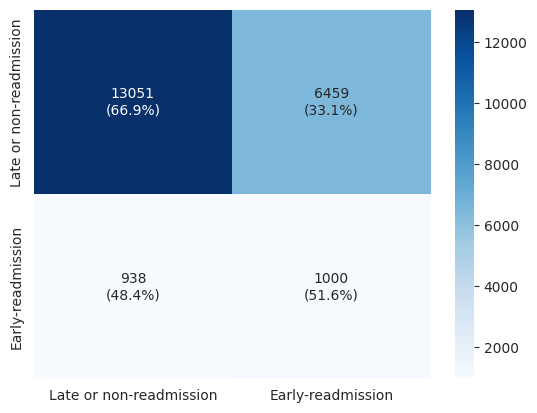

In [51]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [52]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 20, step=2),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        XGBClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [53]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-05 16:33:34,837] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [54]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-05 16:33:40,559] Trial 1 finished with value: 0.49929413874704603 and parameters: {'max_depth': 4, 'learning_rate': 0.002331088768712995, 'min_child_weight': 63}. Best is trial 1 with value: 0.49929413874704603.


Cross validation scores: [0.49176433 0.46921037 0.50728658 0.52866189 0.49954752]
Average score: 0.49929413874704603


[I 2025-01-05 16:33:42,440] Trial 10 finished with value: 0.5257152255759179 and parameters: {'max_depth': 6, 'learning_rate': 0.005037408009002403, 'min_child_weight': 34}. Best is trial 10 with value: 0.5257152255759179.
[I 2025-01-05 16:33:42,443] Trial 3 finished with value: 0.5070511322708905 and parameters: {'max_depth': 6, 'learning_rate': 0.060558986120330366, 'min_child_weight': 23}. Best is trial 10 with value: 0.5257152255759179.


Cross validation scores: [0.50689927 0.5113544  0.50865858 0.50572701 0.50261641]Cross validation scores: [0.51158545 0.51006013 0.5469598  0.53342611 0.52654463]
Average score: 0.5257152255759179

Average score: 0.5070511322708905


[I 2025-01-05 16:33:42,890] Trial 7 finished with value: 0.5373237338296827 and parameters: {'max_depth': 6, 'learning_rate': 0.018343181449819595, 'min_child_weight': 88}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.53673618 0.53992705 0.54593547 0.53428221 0.52973776]
Average score: 0.5373237338296827


[I 2025-01-05 16:33:44,052] Trial 0 finished with value: 0.4671257668309782 and parameters: {'max_depth': 8, 'learning_rate': 0.001199196105534944, 'min_child_weight': 70}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.46878021 0.46668066 0.47207432 0.46207697 0.46601667]
Average score: 0.4671257668309782


[I 2025-01-05 16:33:45,885] Trial 8 finished with value: 0.49009896855313606 and parameters: {'max_depth': 10, 'learning_rate': 0.0013543117776618455, 'min_child_weight': 48}. Best is trial 7 with value: 0.5373237338296827.
[I 2025-01-05 16:33:45,998] Trial 5 finished with value: 0.49358710525128674 and parameters: {'max_depth': 10, 'learning_rate': 0.0010529067364254117, 'min_child_weight': 26}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.49000059 0.49342244 0.49083639 0.4877346  0.48850083]
Average score: 0.49009896855313606
Cross validation scores: [0.49616102 0.48977375 0.50069862 0.48741891 0.49388322]
Average score: 0.49358710525128674


[I 2025-01-05 16:33:46,203] Trial 6 finished with value: 0.4870208468765987 and parameters: {'max_depth': 10, 'learning_rate': 0.06899737193167577, 'min_child_weight': 30}. Best is trial 7 with value: 0.5373237338296827.
[I 2025-01-05 16:33:46,207] Trial 9 finished with value: 0.5181916293406925 and parameters: {'max_depth': 10, 'learning_rate': 0.026002871444574503, 'min_child_weight': 80}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.51839989 0.51388329 0.52392804 0.52306194 0.51168499]
Average score: 0.5181916293406925
Cross validation scores: [0.48724498 0.48848691 0.48770055 0.48940967 0.48226212]
Average score: 0.4870208468765987


[I 2025-01-05 16:33:48,716] Trial 11 finished with value: 0.5169312295864573 and parameters: {'max_depth': 12, 'learning_rate': 0.020820712907084326, 'min_child_weight': 43}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.51943325 0.5183084  0.51832241 0.51592804 0.51266405]
Average score: 0.5169312295864573


[I 2025-01-05 16:33:50,928] Trial 4 finished with value: 0.4901439161971858 and parameters: {'max_depth': 16, 'learning_rate': 0.0629794367890505, 'min_child_weight': 22}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.49306755 0.49470527 0.48637975 0.48907287 0.48749414]
Average score: 0.4901439161971858


[I 2025-01-05 16:33:51,751] Trial 12 finished with value: 0.5003549096513271 and parameters: {'max_depth': 10, 'learning_rate': 0.03941671993494128, 'min_child_weight': 43}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.49668272 0.50422222 0.50013306 0.50705591 0.49368064]
Average score: 0.5003549096513271


[I 2025-01-05 16:33:52,524] Trial 17 finished with value: 0.4994063131221059 and parameters: {'max_depth': 4, 'learning_rate': 0.0023381965623444825, 'min_child_weight': 48}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.49176433 0.46921037 0.50728658 0.52866189 0.50010839]
Average score: 0.4994063131221059


[I 2025-01-05 16:33:54,307] Trial 2 finished with value: 0.5118127800064036 and parameters: {'max_depth': 18, 'learning_rate': 0.010574893438355971, 'min_child_weight': 12}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.51429279 0.510394   0.51317232 0.5090742  0.51213059]
Average score: 0.5118127800064036


[I 2025-01-05 16:33:55,480] Trial 16 finished with value: 0.5250001073374094 and parameters: {'max_depth': 10, 'learning_rate': 0.007162862693422055, 'min_child_weight': 37}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.52549085 0.52616837 0.53360745 0.5270133  0.51272056]
Average score: 0.5250001073374094


[I 2025-01-05 16:33:55,816] Trial 18 finished with value: 0.4677834819101728 and parameters: {'max_depth': 8, 'learning_rate': 0.002010555633817929, 'min_child_weight': 52}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.46669821 0.46698098 0.47481938 0.46159985 0.46881899]
Average score: 0.4677834819101728


[I 2025-01-05 16:33:58,407] Trial 14 finished with value: 0.5199375557435786 and parameters: {'max_depth': 16, 'learning_rate': 0.0015474321812599162, 'min_child_weight': 56}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.51560956 0.51907175 0.52086936 0.52744207 0.51669504]
Average score: 0.5199375557435786


[I 2025-01-05 16:33:58,849] Trial 22 finished with value: 0.5264410121785554 and parameters: {'max_depth': 6, 'learning_rate': 0.005825939043898011, 'min_child_weight': 95}. Best is trial 7 with value: 0.5373237338296827.


Cross validation scores: [0.51255452 0.50951578 0.55081589 0.53469234 0.52462653]
Average score: 0.5264410121785554


[I 2025-01-05 16:33:59,260] Trial 24 finished with value: 0.5385789734754132 and parameters: {'max_depth': 4, 'learning_rate': 0.012981512600953529, 'min_child_weight': 2}. Best is trial 24 with value: 0.5385789734754132.


Cross validation scores: [0.53725303 0.52997174 0.55247945 0.54184202 0.53134863]
Average score: 0.5385789734754132


[I 2025-01-05 16:33:59,761] Trial 23 finished with value: 0.518436576657195 and parameters: {'max_depth': 6, 'learning_rate': 0.004168120344052099, 'min_child_weight': 81}. Best is trial 24 with value: 0.5385789734754132.


Cross validation scores: [0.5033499  0.49169476 0.5505051  0.5346952  0.51193793]
Average score: 0.518436576657195


[I 2025-01-05 16:34:00,902] Trial 13 finished with value: 0.49210977682089563 and parameters: {'max_depth': 18, 'learning_rate': 0.05516809667559735, 'min_child_weight': 9}. Best is trial 24 with value: 0.5385789734754132.


Cross validation scores: [0.49201196 0.49159897 0.49784147 0.49405344 0.48504304]
Average score: 0.49210977682089563


[I 2025-01-05 16:34:02,640] Trial 19 finished with value: 0.5229903790303021 and parameters: {'max_depth': 16, 'learning_rate': 0.0037663030980280795, 'min_child_weight': 44}. Best is trial 24 with value: 0.5385789734754132.


Cross validation scores: [0.51501038 0.52497291 0.52640128 0.52717989 0.52138743]
Average score: 0.5229903790303021


[I 2025-01-05 16:34:03,008] Trial 21 finished with value: 0.5292729875934332 and parameters: {'max_depth': 14, 'learning_rate': 0.012275406560573287, 'min_child_weight': 97}. Best is trial 24 with value: 0.5385789734754132.


Cross validation scores: [0.53016117 0.52739212 0.52625422 0.52773061 0.53482682]
Average score: 0.5292729875934332


[I 2025-01-05 16:34:03,410] Trial 15 finished with value: 0.5176092278077362 and parameters: {'max_depth': 20, 'learning_rate': 0.00109813361432268, 'min_child_weight': 23}. Best is trial 24 with value: 0.5385789734754132.
[I 2025-01-05 16:34:03,431] Trial 25 finished with value: 0.48866143299983633 and parameters: {'max_depth': 8, 'learning_rate': 0.09736768013931431, 'min_child_weight': 80}. Best is trial 24 with value: 0.5385789734754132.


Cross validation scores: [0.51500114 0.50958459 0.52028957 0.52665377 0.51651707]
Average score: 0.5176092278077362
Cross validation scores: [0.4925925  0.48983977 0.4925925  0.48271895 0.48556345]
Average score: 0.48866143299983633


[I 2025-01-05 16:34:03,739] Trial 27 finished with value: 0.5133472693502956 and parameters: {'max_depth': 6, 'learning_rate': 0.003742593324764677, 'min_child_weight': 65}. Best is trial 24 with value: 0.5385789734754132.


Cross validation scores: [0.50483511 0.46448451 0.54905521 0.53572505 0.51263646]
Average score: 0.5133472693502956


[I 2025-01-05 16:34:04,345] Trial 20 finished with value: 0.5101032710265362 and parameters: {'max_depth': 20, 'learning_rate': 0.02116732540792075, 'min_child_weight': 53}. Best is trial 24 with value: 0.5385789734754132.


Cross validation scores: [0.51337574 0.50914589 0.51179257 0.50636144 0.50984071]
Average score: 0.5101032710265362


[I 2025-01-05 16:34:05,626] Trial 30 finished with value: 0.5399560743014149 and parameters: {'max_depth': 4, 'learning_rate': 0.01382709261850698, 'min_child_weight': 13}. Best is trial 30 with value: 0.5399560743014149.


Cross validation scores: [0.5380727  0.53202559 0.55463304 0.54266015 0.5323889 ]
Average score: 0.5399560743014149


[I 2025-01-05 16:34:06,137] Trial 31 finished with value: 0.5380843719818444 and parameters: {'max_depth': 4, 'learning_rate': 0.009291620642552659, 'min_child_weight': 72}. Best is trial 30 with value: 0.5399560743014149.


Cross validation scores: [0.53870963 0.52747448 0.55178648 0.54227847 0.53017279]
Average score: 0.5380843719818444


[I 2025-01-05 16:34:07,593] Trial 26 finished with value: 0.5258298759767879 and parameters: {'max_depth': 12, 'learning_rate': 0.007566657678476863, 'min_child_weight': 89}. Best is trial 30 with value: 0.5399560743014149.


Cross validation scores: [0.52175535 0.51228901 0.53867557 0.52439926 0.53203018]
Average score: 0.5258298759767879


[I 2025-01-05 16:34:07,903] Trial 28 finished with value: 0.5397313275670939 and parameters: {'max_depth': 8, 'learning_rate': 0.016082709009115057, 'min_child_weight': 70}. Best is trial 30 with value: 0.5399560743014149.


Cross validation scores: [0.53839232 0.54132794 0.54727862 0.54213925 0.5295185 ]
Average score: 0.5397313275670939


[I 2025-01-05 16:34:08,693] Trial 32 finished with value: 0.5262670881113864 and parameters: {'max_depth': 6, 'learning_rate': 0.005519868200368996, 'min_child_weight': 90}. Best is trial 30 with value: 0.5399560743014149.
[I 2025-01-05 16:34:08,845] Trial 33 finished with value: 0.5393042184401948 and parameters: {'max_depth': 4, 'learning_rate': 0.016935843324491193, 'min_child_weight': 90}. Best is trial 30 with value: 0.5399560743014149.


Cross validation scores: [0.51210212 0.51067574 0.55021501 0.5344105  0.52393207]
Average score: 0.5262670881113864
Cross validation scores: [0.53883669 0.54254335 0.55366293 0.53150832 0.52996981]
Average score: 0.5393042184401948


[I 2025-01-05 16:34:10,800] Trial 29 finished with value: 0.5068080030590328 and parameters: {'max_depth': 12, 'learning_rate': 0.03454083274042919, 'min_child_weight': 98}. Best is trial 30 with value: 0.5399560743014149.


Cross validation scores: [0.5057177  0.50829374 0.50631079 0.5063731  0.50734468]
Average score: 0.5068080030590328


[I 2025-01-05 16:34:11,837] Trial 39 finished with value: 0.5386544809399245 and parameters: {'max_depth': 4, 'learning_rate': 0.01529080921460151, 'min_child_weight': 16}. Best is trial 30 with value: 0.5399560743014149.


Cross validation scores: [0.53845955 0.53985011 0.55470005 0.53205089 0.52821181]
Average score: 0.5386544809399245


[I 2025-01-05 16:34:12,286] Trial 40 finished with value: 0.5385012784384643 and parameters: {'max_depth': 4, 'learning_rate': 0.008919819105800022, 'min_child_weight': 16}. Best is trial 30 with value: 0.5399560743014149.


Cross validation scores: [0.53878362 0.52835369 0.55271219 0.54217493 0.53048195]
Average score: 0.5385012784384643


[I 2025-01-05 16:34:13,781] Trial 38 finished with value: 0.541910426135576 and parameters: {'max_depth': 8, 'learning_rate': 0.011855185072255485, 'min_child_weight': 73}. Best is trial 38 with value: 0.541910426135576.
[I 2025-01-05 16:34:13,903] Trial 41 finished with value: 0.5009808357262479 and parameters: {'max_depth': 4, 'learning_rate': 0.003103111773205776, 'min_child_weight': 3}. Best is trial 38 with value: 0.541910426135576.
[I 2025-01-05 16:34:13,962] Trial 42 finished with value: 0.540617939980098 and parameters: {'max_depth': 4, 'learning_rate': 0.013409587989163507, 'min_child_weight': 70}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53666216 0.54638265 0.55111789 0.54325804 0.53213138]
Average score: 0.541910426135576
Cross validation scores: [0.49700027 0.47094047 0.50876791 0.52859524 0.49960029]
Average score: 0.5009808357262479
Cross validation scores: [0.53841458 0.53364778 0.55428748 0.54480799 0.53193187]
Average score: 0.540617939980098


[I 2025-01-05 16:34:16,697] Trial 45 finished with value: 0.538619392707877 and parameters: {'max_depth': 4, 'learning_rate': 0.02857881826213288, 'min_child_weight': 64}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53676493 0.5331397  0.55437418 0.53617063 0.53264751]
Average score: 0.538619392707877


[I 2025-01-05 16:34:17,076] Trial 35 finished with value: 0.5302191014760316 and parameters: {'max_depth': 14, 'learning_rate': 0.009642402890091889, 'min_child_weight': 100}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.52814128 0.53087923 0.52230572 0.53164005 0.53812923]
Average score: 0.5302191014760316


[I 2025-01-05 16:34:17,516] Trial 34 finished with value: 0.529349366901542 and parameters: {'max_depth': 14, 'learning_rate': 0.012409727135164212, 'min_child_weight': 60}. Best is trial 38 with value: 0.541910426135576.
[I 2025-01-05 16:34:17,556] Trial 43 finished with value: 0.5328308529584221 and parameters: {'max_depth': 8, 'learning_rate': 0.007525554974736699, 'min_child_weight': 75}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.52862008 0.52582744 0.53141287 0.52833004 0.53255641]
Average score: 0.529349366901542
Cross validation scores: [0.52054184 0.52912282 0.55464263 0.5372712  0.52257577]
Average score: 0.5328308529584221


[I 2025-01-05 16:34:18,255] Trial 44 finished with value: 0.5356857745657948 and parameters: {'max_depth': 8, 'learning_rate': 0.016569236260619423, 'min_child_weight': 10}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53554745 0.54028983 0.54483046 0.52882719 0.52893393]
Average score: 0.5356857745657948


[I 2025-01-05 16:34:19,216] Trial 36 finished with value: 0.5004898325687608 and parameters: {'max_depth': 14, 'learning_rate': 0.03338621932336781, 'min_child_weight': 3}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.50484606 0.5040738  0.50510861 0.49339619 0.4950245 ]
Average score: 0.5004898325687608
Cross validation scores: [0.51386121 0.50158379 0.51987382 0.51032895 0.51044265]
Average score: 0.5112180824153534


[I 2025-01-05 16:34:19,413] Trial 37 finished with value: 0.5112180824153534 and parameters: {'max_depth': 18, 'learning_rate': 0.024371948776287004, 'min_child_weight': 83}. Best is trial 38 with value: 0.541910426135576.
[I 2025-01-05 16:34:19,654] Trial 46 finished with value: 0.5396598130589976 and parameters: {'max_depth': 6, 'learning_rate': 0.016296859700336667, 'min_child_weight': 18}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.54266848 0.54662852 0.54516135 0.53074584 0.53309487]
Average score: 0.5396598130589976


[I 2025-01-05 16:34:20,147] Trial 47 finished with value: 0.5161546949810008 and parameters: {'max_depth': 6, 'learning_rate': 0.04675518891478628, 'min_child_weight': 28}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.52176418 0.51649624 0.51821724 0.50845515 0.51584066]
Average score: 0.5161546949810008


[I 2025-01-05 16:34:22,589] Trial 52 finished with value: 0.5417306729824879 and parameters: {'max_depth': 4, 'learning_rate': 0.015452234924588802, 'min_child_weight': 85}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.54046437 0.54051758 0.55469259 0.54232127 0.53065755]
Average score: 0.5417306729824879


[I 2025-01-05 16:34:23,025] Trial 49 finished with value: 0.5400684964962056 and parameters: {'max_depth': 8, 'learning_rate': 0.01094725386040798, 'min_child_weight': 76}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53403302 0.54376154 0.55143619 0.54412801 0.52698372]
Average score: 0.5400684964962056


[I 2025-01-05 16:34:23,310] Trial 48 finished with value: 0.5339297344767612 and parameters: {'max_depth': 8, 'learning_rate': 0.019983496573854877, 'min_child_weight': 68}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.52810788 0.53714687 0.54181163 0.53965362 0.52292868]
Average score: 0.5339297344767612


[I 2025-01-05 16:34:23,606] Trial 54 finished with value: 0.5397983802044461 and parameters: {'max_depth': 4, 'learning_rate': 0.020096830888829614, 'min_child_weight': 92}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53862679 0.54204461 0.55641974 0.53218665 0.52971412]
Average score: 0.5397983802044461


[I 2025-01-05 16:34:24,747] Trial 50 finished with value: 0.5331688501961018 and parameters: {'max_depth': 10, 'learning_rate': 0.013565397597165466, 'min_child_weight': 58}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53317758 0.52653896 0.54435424 0.5343736  0.52739987]
Average score: 0.5331688501961018


[I 2025-01-05 16:34:24,964] Trial 53 finished with value: 0.5408312090001992 and parameters: {'max_depth': 6, 'learning_rate': 0.01105181045704486, 'min_child_weight': 68}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.54104055 0.54526747 0.54666358 0.53736991 0.53381453]
Average score: 0.5408312090001992


[I 2025-01-05 16:34:25,280] Trial 57 finished with value: 0.5312528070332047 and parameters: {'max_depth': 4, 'learning_rate': 0.006671778300041889, 'min_child_weight': 75}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.52420673 0.51700593 0.55216897 0.53716562 0.5257168 ]
Average score: 0.5312528070332047


[I 2025-01-05 16:34:25,824] Trial 55 finished with value: 0.5401361981453242 and parameters: {'max_depth': 6, 'learning_rate': 0.008212478632305429, 'min_child_weight': 36}. Best is trial 38 with value: 0.541910426135576.
[I 2025-01-05 16:34:25,876] Trial 51 finished with value: 0.5281644945795848 and parameters: {'max_depth': 8, 'learning_rate': 0.024395468630378923, 'min_child_weight': 71}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53388747 0.54469395 0.54338896 0.5397334  0.53897722]
Average score: 0.5401361981453242
Cross validation scores: [0.52286714 0.53337981 0.53405359 0.53198263 0.5185393 ]
Average score: 0.5281644945795848


[I 2025-01-05 16:34:27,053] Trial 58 finished with value: 0.5391881398573052 and parameters: {'max_depth': 6, 'learning_rate': 0.01471614512486011, 'min_child_weight': 20}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.54306166 0.54391538 0.54771823 0.53174448 0.52950094]
Average score: 0.5391881398573052


[I 2025-01-05 16:34:27,540] Trial 59 finished with value: 0.5400751752242584 and parameters: {'max_depth': 6, 'learning_rate': 0.01095673610056614, 'min_child_weight': 32}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.54005655 0.54469044 0.54444793 0.536047   0.53513395]
Average score: 0.5400751752242584


[I 2025-01-05 16:34:29,328] Trial 63 finished with value: 0.5400357721601736 and parameters: {'max_depth': 4, 'learning_rate': 0.020368081164452018, 'min_child_weight': 93}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.54037574 0.54060656 0.55634035 0.53307486 0.52978135]
Average score: 0.5400357721601736


[I 2025-01-05 16:34:29,912] Trial 56 finished with value: 0.5141558481931692 and parameters: {'max_depth': 10, 'learning_rate': 0.027386785169171812, 'min_child_weight': 61}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.51246241 0.52005665 0.50973953 0.51616861 0.51235204]
Average score: 0.5141558481931692


[I 2025-01-05 16:34:30,624] Trial 64 finished with value: 0.5394049461036808 and parameters: {'max_depth': 4, 'learning_rate': 0.018704970786359805, 'min_child_weight': 76}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53603269 0.54217889 0.55528955 0.53191297 0.53161063]
Average score: 0.5394049461036808


[I 2025-01-05 16:34:31,918] Trial 61 finished with value: 0.5410840140323584 and parameters: {'max_depth': 8, 'learning_rate': 0.011256547890563377, 'min_child_weight': 78}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53106859 0.5471662  0.5522995  0.54317312 0.53171267]
Average score: 0.5410840140323584


[I 2025-01-05 16:34:32,435] Trial 65 finished with value: 0.5404011466307683 and parameters: {'max_depth': 6, 'learning_rate': 0.010426808342691137, 'min_child_weight': 73}. Best is trial 38 with value: 0.541910426135576.
[I 2025-01-05 16:34:32,558] Trial 62 finished with value: 0.5403318573655719 and parameters: {'max_depth': 8, 'learning_rate': 0.013488416848690829, 'min_child_weight': 86}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53852903 0.54294502 0.54945498 0.53833009 0.53274662]
Average score: 0.5404011466307683
Cross validation scores: [0.53043646 0.54563411 0.55603989 0.54105488 0.52849395]
Average score: 0.5403318573655719


[I 2025-01-05 16:34:32,748] Trial 66 finished with value: 0.5402847853442627 and parameters: {'max_depth': 6, 'learning_rate': 0.011394924444900936, 'min_child_weight': 66}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.54163498 0.54562119 0.54787208 0.53529169 0.53100399]
Average score: 0.5402847853442627


[I 2025-01-05 16:34:33,231] Trial 67 finished with value: 0.5393244731144293 and parameters: {'max_depth': 6, 'learning_rate': 0.008234599655291375, 'min_child_weight': 38}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53529724 0.54327522 0.54382584 0.54099043 0.53323365]
Average score: 0.5393244731144293


[I 2025-01-05 16:34:33,475] Trial 68 finished with value: 0.5280436200745371 and parameters: {'max_depth': 6, 'learning_rate': 0.005158965588498531, 'min_child_weight': 54}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.52399174 0.50997016 0.54632354 0.53390535 0.52602731]
Average score: 0.5280436200745371


[I 2025-01-05 16:34:34,286] Trial 60 finished with value: 0.5218099768493217 and parameters: {'max_depth': 12, 'learning_rate': 0.0064950458622017055, 'min_child_weight': 84}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.51782642 0.50725436 0.53254469 0.5216061  0.52981831]
Average score: 0.5218099768493217


[I 2025-01-05 16:34:35,066] Trial 70 finished with value: 0.539359960912223 and parameters: {'max_depth': 6, 'learning_rate': 0.008231961290071324, 'min_child_weight': 34}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53434377 0.54327522 0.54331833 0.53888313 0.53697936]
Average score: 0.539359960912223


[I 2025-01-05 16:34:36,015] Trial 69 finished with value: 0.5022800377018285 and parameters: {'max_depth': 8, 'learning_rate': 0.004288696526869056, 'min_child_weight': 48}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.49925367 0.50499302 0.51366796 0.4990742  0.49441133]
Average score: 0.5022800377018285


[I 2025-01-05 16:34:37,081] Trial 71 finished with value: 0.5385255607468009 and parameters: {'max_depth': 6, 'learning_rate': 0.00958980955304069, 'min_child_weight': 39}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53224812 0.54349588 0.54324135 0.54050883 0.53313362]
Average score: 0.5385255607468009


[I 2025-01-05 16:34:37,585] Trial 72 finished with value: 0.5410640982565769 and parameters: {'max_depth': 6, 'learning_rate': 0.011536405635569295, 'min_child_weight': 32}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.54228926 0.54594981 0.5466909  0.53546826 0.53492226]
Average score: 0.5410640982565769


[I 2025-01-05 16:34:37,966] Trial 74 finished with value: 0.5373034543674536 and parameters: {'max_depth': 4, 'learning_rate': 0.008369517875056442, 'min_child_weight': 43}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53838403 0.52692145 0.55237616 0.53939177 0.52944386]
Average score: 0.5373034543674536


[I 2025-01-05 16:34:39,790] Trial 73 finished with value: 0.5282827535520596 and parameters: {'max_depth': 8, 'learning_rate': 0.006671957102937956, 'min_child_weight': 79}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.51816313 0.51872233 0.55494434 0.53780628 0.51177768]
Average score: 0.5282827535520596


[I 2025-01-05 16:34:40,192] Trial 80 finished with value: 0.5394049341026114 and parameters: {'max_depth': 4, 'learning_rate': 0.01810003908019964, 'min_child_weight': 87}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53979611 0.54127389 0.55443179 0.53118402 0.53033885]
Average score: 0.5394049341026114


[I 2025-01-05 16:34:41,889] Trial 76 finished with value: 0.5411821697475531 and parameters: {'max_depth': 8, 'learning_rate': 0.013006532285119455, 'min_child_weight': 86}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53004687 0.54787458 0.5578493  0.54325804 0.52688206]
Average score: 0.5411821697475531


[I 2025-01-05 16:34:42,168] Trial 77 finished with value: 0.5412506861425481 and parameters: {'max_depth': 8, 'learning_rate': 0.014788253329218425, 'min_child_weight': 73}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53752317 0.54527823 0.55027954 0.54353601 0.52963649]
Average score: 0.5412506861425481


[I 2025-01-05 16:34:42,536] Trial 79 finished with value: 0.5409084421575822 and parameters: {'max_depth': 8, 'learning_rate': 0.010662886806408766, 'min_child_weight': 78}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53103882 0.5457144  0.55289491 0.54250267 0.53239142]
Average score: 0.5409084421575822


[I 2025-01-05 16:34:43,304] Trial 75 finished with value: 0.5328484163461058 and parameters: {'max_depth': 10, 'learning_rate': 0.00974049388006601, 'min_child_weight': 68}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.52942381 0.5274304  0.5454503  0.53687756 0.52506002]
Average score: 0.5328484163461058


[I 2025-01-05 16:34:43,767] Trial 78 finished with value: 0.5245270618529514 and parameters: {'max_depth': 10, 'learning_rate': 0.02292460444995069, 'min_child_weight': 79}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.522218   0.52226186 0.53497793 0.52493434 0.51824317]
Average score: 0.5245270618529514


[I 2025-01-05 16:34:44,053] Trial 82 finished with value: 0.5402872924889734 and parameters: {'max_depth': 6, 'learning_rate': 0.01032584160026778, 'min_child_weight': 67}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53959021 0.54368637 0.5474869  0.53847554 0.53219744]
Average score: 0.5402872924889734


[I 2025-01-05 16:34:44,579] Trial 83 finished with value: 0.539769487740902 and parameters: {'max_depth': 6, 'learning_rate': 0.01178371827321281, 'min_child_weight': 61}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53871314 0.54520833 0.54576199 0.53438071 0.53478326]
Average score: 0.539769487740902


[I 2025-01-05 16:34:45,054] Trial 84 finished with value: 0.5406898758736676 and parameters: {'max_depth': 6, 'learning_rate': 0.014126635504834747, 'min_child_weight': 85}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.54117615 0.54565543 0.54964424 0.53367187 0.53330168]
Average score: 0.5406898758736676


[I 2025-01-05 16:34:45,731] Trial 86 finished with value: 0.5396793909623689 and parameters: {'max_depth': 4, 'learning_rate': 0.01691223840776329, 'min_child_weight': 82}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53944927 0.54284428 0.55368843 0.53117064 0.53124434]
Average score: 0.5396793909623689


[I 2025-01-05 16:34:47,665] Trial 81 finished with value: 0.5301181099447716 and parameters: {'max_depth': 12, 'learning_rate': 0.012371229119044206, 'min_child_weight': 83}. Best is trial 38 with value: 0.541910426135576.
[I 2025-01-05 16:34:47,845] Trial 85 finished with value: 0.527955565296854 and parameters: {'max_depth': 8, 'learning_rate': 0.006027552677900039, 'min_child_weight': 70}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.5259536  0.52598722 0.53730945 0.53045351 0.53088676]
Average score: 0.5301181099447716
Cross validation scores: [0.51700282 0.52093165 0.55314669 0.5390115  0.50968517]
Average score: 0.527955565296854


[I 2025-01-05 16:34:49,608] Trial 87 finished with value: 0.5418026812245912 and parameters: {'max_depth': 8, 'learning_rate': 0.012888172260477783, 'min_child_weight': 72}. Best is trial 38 with value: 0.541910426135576.
[I 2025-01-05 16:34:49,785] Trial 88 finished with value: 0.5408617000601472 and parameters: {'max_depth': 6, 'learning_rate': 0.009137065971025498, 'min_child_weight': 77}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53534223 0.54666033 0.55099132 0.54391882 0.53210071]
Average score: 0.5418026812245912
Cross validation scores: [0.53824669 0.54303239 0.54975191 0.5398264  0.53345112]
Average score: 0.5408617000601472


[I 2025-01-05 16:34:51,787] Trial 90 finished with value: 0.516353992927081 and parameters: {'max_depth': 8, 'learning_rate': 0.03223515127017483, 'min_child_weight': 80}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.51482843 0.51368435 0.52173747 0.51755244 0.51396727]
Average score: 0.516353992927081


[I 2025-01-05 16:34:52,951] Trial 89 finished with value: 0.5320586228303886 and parameters: {'max_depth': 10, 'learning_rate': 0.01526944219620025, 'min_child_weight': 74}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.52690084 0.52742374 0.54663815 0.52901575 0.53031463]
Average score: 0.5320586228303886


[I 2025-01-05 16:34:53,185] Trial 93 finished with value: 0.536667852652022 and parameters: {'max_depth': 8, 'learning_rate': 0.01840832835791627, 'min_child_weight': 79}. Best is trial 38 with value: 0.541910426135576.
[I 2025-01-05 16:34:53,211] Trial 92 finished with value: 0.5403048267656935 and parameters: {'max_depth': 8, 'learning_rate': 0.010630307427223741, 'min_child_weight': 77}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.52979209 0.54290077 0.5472644  0.53896409 0.52441791]
Average score: 0.536667852652022
Cross validation scores: [0.53082377 0.54619652 0.55161444 0.54258363 0.53030577]
Average score: 0.5403048267656935


[I 2025-01-05 16:34:53,537] Trial 94 finished with value: 0.5404976544118236 and parameters: {'max_depth': 8, 'learning_rate': 0.0145931864752793, 'min_child_weight': 25}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53974414 0.54806495 0.54594204 0.53839741 0.53033972]
Average score: 0.5404976544118236


[I 2025-01-05 16:34:53,797] Trial 91 finished with value: 0.5341578761585727 and parameters: {'max_depth': 10, 'learning_rate': 0.011767842856267459, 'min_child_weight': 88}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.52745712 0.53043425 0.54970889 0.53261833 0.53057079]
Average score: 0.5341578761585727


[I 2025-01-05 16:34:54,186] Trial 96 finished with value: 0.541317132437412 and parameters: {'max_depth': 8, 'learning_rate': 0.0141631079617952, 'min_child_weight': 87}. Best is trial 38 with value: 0.541910426135576.
[I 2025-01-05 16:34:54,314] Trial 98 finished with value: 0.5357540962710176 and parameters: {'max_depth': 6, 'learning_rate': 0.0070664460063665615, 'min_child_weight': 85}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.53211438 0.54680922 0.55571178 0.54189702 0.53005326]
Average score: 0.541317132437412
Cross validation scores: [0.52328726 0.54433091 0.54961625 0.53561403 0.52592203]
Average score: 0.5357540962710176


[I 2025-01-05 16:34:54,594] Trial 95 finished with value: 0.5257566925764604 and parameters: {'max_depth': 10, 'learning_rate': 0.022420829725571148, 'min_child_weight': 84}. Best is trial 38 with value: 0.541910426135576.
[I 2025-01-05 16:34:54,755] Trial 97 finished with value: 0.5396743202900192 and parameters: {'max_depth': 8, 'learning_rate': 0.015863949261529158, 'min_child_weight': 96}. Best is trial 38 with value: 0.541910426135576.


Cross validation scores: [0.52358177 0.52484272 0.53565485 0.52617168 0.51853245]
Average score: 0.5257566925764604
Cross validation scores: [0.53638534 0.54343935 0.55159253 0.53675503 0.53019934]
Average score: 0.5396743202900192


[I 2025-01-05 16:34:55,080] Trial 99 finished with value: 0.5444816509289224 and parameters: {'max_depth': 8, 'learning_rate': 0.012375756733560141, 'min_child_weight': 63}. Best is trial 99 with value: 0.5444816509289224.


Cross validation scores: [0.54108015 0.55156976 0.55239812 0.54692881 0.53043142]
Average score: 0.5444816509289224


In [55]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 99
Best Parameters: {'max_depth': 8, 'learning_rate': 0.012375756733560141, 'min_child_weight': 63}
Best Value: 0.5444816509289224


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [56]:
optuna.visualization.plot_optimization_history(study)

In [57]:
optuna.visualization.plot_slice(study)

In [58]:
optuna.visualization.plot_param_importances(study)

In [59]:
optuna.visualization.plot_parallel_coordinate(study)

In [60]:
optuna.visualization.plot_contour(study)

In [61]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [62]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    XGBClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.012375756733560141, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=63,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=38, ...))])

In [63]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [64]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.8262164052352883
Test accuracy:  0.8225941812756434


In [65]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.88      0.90     19510
      Early-readmission       0.16      0.23      0.19      1938

               accuracy                           0.82     21448
              macro avg       0.54      0.56      0.55     21448
           weighted avg       0.85      0.82      0.84     21448



In [66]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

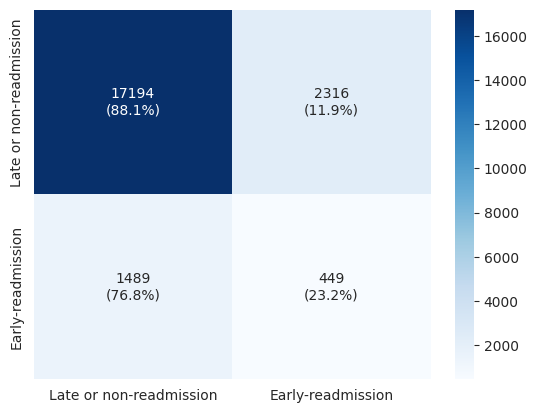

In [67]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [68]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 20, step=2),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        XGBClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [69]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-05 16:34:56,312] A new study created in Journal with name: Diabetes_130-US


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [70]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-05 16:35:44,583] Trial 3 finished with value: 0.5175264546341837 and parameters: {'max_depth': 4, 'learning_rate': 0.08185046275952075, 'min_child_weight': 92}. Best is trial 3 with value: 0.5175264546341837.


Cross validation scores: [0.5111353  0.52028717 0.52049571 0.52224398 0.51347011]
Average score: 0.5175264546341837


[I 2025-01-05 16:35:46,670] Trial 7 finished with value: 0.535124935021263 and parameters: {'max_depth': 4, 'learning_rate': 0.034685844358684555, 'min_child_weight': 49}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.53545399 0.53186059 0.54689007 0.53134023 0.5300798 ]
Average score: 0.535124935021263


[I 2025-01-05 16:35:51,710] Trial 6 finished with value: 0.49274445446945875 and parameters: {'max_depth': 10, 'learning_rate': 0.05529155161672241, 'min_child_weight': 54}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.49094483 0.50171031 0.49529866 0.48575263 0.49001584]
Average score: 0.49274445446945875


[I 2025-01-05 16:35:52,804] Trial 2 finished with value: 0.4735899605755199 and parameters: {'max_depth': 8, 'learning_rate': 0.002802767379454686, 'min_child_weight': 95}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.46878021 0.4679217  0.49033316 0.47658879 0.46432594]
Average score: 0.4735899605755199


[I 2025-01-05 16:35:53,161] Trial 4 finished with value: 0.5058490152412365 and parameters: {'max_depth': 14, 'learning_rate': 0.03439491558412278, 'min_child_weight': 70}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.50459133 0.50659415 0.50544225 0.5014859  0.51113145]
Average score: 0.5058490152412365


[I 2025-01-05 16:35:54,788] Trial 9 finished with value: 0.5096796521944104 and parameters: {'max_depth': 10, 'learning_rate': 0.00526806680834966, 'min_child_weight': 32}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.51513233 0.50338203 0.51936873 0.50688079 0.50363439]
Average score: 0.5096796521944104


[I 2025-01-05 16:35:56,912] Trial 0 finished with value: 0.5264872756880868 and parameters: {'max_depth': 16, 'learning_rate': 0.015925981974686088, 'min_child_weight': 88}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.52394897 0.5312577  0.52172497 0.53263662 0.52286812]
Average score: 0.5264872756880868


[I 2025-01-05 16:35:59,689] Trial 10 finished with value: 0.4894076485460209 and parameters: {'max_depth': 20, 'learning_rate': 0.07235408266151439, 'min_child_weight': 61}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.49476075 0.48451839 0.49362115 0.48771853 0.48641942]
Average score: 0.4894076485460209


[I 2025-01-05 16:35:59,904] Trial 8 finished with value: 0.5180698532396695 and parameters: {'max_depth': 16, 'learning_rate': 0.001110844116448096, 'min_child_weight': 91}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.51735379 0.51865328 0.51299545 0.5214777  0.51986904]
Average score: 0.5180698532396695


[I 2025-01-05 16:36:00,930] Trial 1 finished with value: 0.5246154799137969 and parameters: {'max_depth': 18, 'learning_rate': 0.006780461014641945, 'min_child_weight': 57}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.52281778 0.51706661 0.52474336 0.53103631 0.52741335]
Average score: 0.5246154799137969


[I 2025-01-05 16:36:03,006] Trial 5 finished with value: 0.51247700300776 and parameters: {'max_depth': 16, 'learning_rate': 0.0010681591326807368, 'min_child_weight': 14}. Best is trial 7 with value: 0.535124935021263.
[I 2025-01-05 16:36:03,049] Trial 11 finished with value: 0.5199375817296175 and parameters: {'max_depth': 16, 'learning_rate': 0.009903053161971306, 'min_child_weight': 13}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.51046691 0.51705076 0.51619955 0.51674512 0.50192267]
Average score: 0.51247700300776
Cross validation scores: [0.51489575 0.52403059 0.51317705 0.52538791 0.52219661]
Average score: 0.5199375817296175


[I 2025-01-05 16:36:39,955] Trial 12 finished with value: 0.53162493858141 and parameters: {'max_depth': 8, 'learning_rate': 0.021550673257155418, 'min_child_weight': 47}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.52212942 0.53100458 0.54304946 0.53709514 0.52484608]
Average score: 0.53162493858141


[I 2025-01-05 16:36:40,163] Trial 13 finished with value: 0.33318971494521576 and parameters: {'max_depth': 4, 'learning_rate': 0.001372444221097106, 'min_child_weight': 59}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.32916392 0.33505974 0.33418532 0.33513883 0.33240076]
Average score: 0.33318971494521576


[I 2025-01-05 16:36:49,069] Trial 15 finished with value: 0.5178285345133864 and parameters: {'max_depth': 10, 'learning_rate': 0.0291536928185526, 'min_child_weight': 76}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.51371699 0.51890928 0.52443    0.52378913 0.50829726]
Average score: 0.5178285345133864


[I 2025-01-05 16:36:49,846] Trial 14 finished with value: 0.5273750732432312 and parameters: {'max_depth': 10, 'learning_rate': 0.015530065621942578, 'min_child_weight': 20}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.52761745 0.52773352 0.53392351 0.52459788 0.523003  ]
Average score: 0.5273750732432312


[I 2025-01-05 16:36:51,604] Trial 18 finished with value: 0.5291496611851214 and parameters: {'max_depth': 6, 'learning_rate': 0.03304413358060324, 'min_child_weight': 5}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.5287243  0.53150333 0.53450485 0.53005404 0.52096179]
Average score: 0.5291496611851214


[I 2025-01-05 16:36:53,474] Trial 21 finished with value: 0.4685599734223106 and parameters: {'max_depth': 6, 'learning_rate': 0.0035550717119301927, 'min_child_weight': 27}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.45916059 0.46310641 0.46792829 0.48649886 0.46610572]
Average score: 0.4685599734223106


[I 2025-01-05 16:36:54,703] Trial 17 finished with value: 0.5037080117686361 and parameters: {'max_depth': 12, 'learning_rate': 0.0010557114517924233, 'min_child_weight': 84}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.50484349 0.50054284 0.50568502 0.5036754  0.50379331]
Average score: 0.5037080117686361


[I 2025-01-05 16:36:56,313] Trial 16 finished with value: 0.4864205726714058 and parameters: {'max_depth': 16, 'learning_rate': 0.07421791815987169, 'min_child_weight': 41}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.48583042 0.48578717 0.488821   0.48321901 0.48844526]
Average score: 0.4864205726714058


[I 2025-01-05 16:36:58,094] Trial 20 finished with value: 0.5064888922065227 and parameters: {'max_depth': 12, 'learning_rate': 0.0020351031473181407, 'min_child_weight': 68}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.50361555 0.50346706 0.51086368 0.50412471 0.51037345]
Average score: 0.5064888922065227


[I 2025-01-05 16:37:03,097] Trial 19 finished with value: 0.5271673793790885 and parameters: {'max_depth': 18, 'learning_rate': 0.00874463667927075, 'min_child_weight': 59}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.52173859 0.52658581 0.52552588 0.53453406 0.52745256]
Average score: 0.5271673793790885


[I 2025-01-05 16:37:06,228] Trial 22 finished with value: 0.5217320834871695 and parameters: {'max_depth': 14, 'learning_rate': 0.019571316405847534, 'min_child_weight': 40}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.52318892 0.52408156 0.52355443 0.52134779 0.51648773]
Average score: 0.5217320834871695


[I 2025-01-05 16:37:07,734] Trial 23 finished with value: 0.5249114551907387 and parameters: {'max_depth': 20, 'learning_rate': 0.01381982969253541, 'min_child_weight': 82}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.51987805 0.5261704  0.52361608 0.5239748  0.53091794]
Average score: 0.5249114551907387


[I 2025-01-05 16:37:33,443] Trial 24 finished with value: 0.5172353781752446 and parameters: {'max_depth': 6, 'learning_rate': 0.04637024532717765, 'min_child_weight': 44}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.51914874 0.51821248 0.51253455 0.52235639 0.51392473]
Average score: 0.5172353781752446


[I 2025-01-05 16:37:36,191] Trial 25 finished with value: 0.5303730268491367 and parameters: {'max_depth': 8, 'learning_rate': 0.022244320502605087, 'min_child_weight': 46}. Best is trial 7 with value: 0.535124935021263.


Cross validation scores: [0.52294356 0.53288637 0.53822959 0.53248663 0.52531899]
Average score: 0.5303730268491367


[I 2025-01-05 16:37:38,898] Trial 26 finished with value: 0.5360957030939326 and parameters: {'max_depth': 4, 'learning_rate': 0.041654394948415184, 'min_child_weight': 33}. Best is trial 26 with value: 0.5360957030939326.


Cross validation scores: [0.53524649 0.53638882 0.54649404 0.53516955 0.52717961]
Average score: 0.5360957030939326


[I 2025-01-05 16:37:44,992] Trial 28 finished with value: 0.5379704929658212 and parameters: {'max_depth': 6, 'learning_rate': 0.013796738800021089, 'min_child_weight': 68}. Best is trial 28 with value: 0.5379704929658212.


Cross validation scores: [0.54105891 0.53830935 0.54878471 0.52993956 0.53175994]
Average score: 0.5379704929658212


[I 2025-01-05 16:37:45,632] Trial 27 finished with value: 0.527542589764625 and parameters: {'max_depth': 8, 'learning_rate': 0.02604375063457305, 'min_child_weight': 49}. Best is trial 28 with value: 0.5379704929658212.


Cross validation scores: [0.51673531 0.53270738 0.53751927 0.53150798 0.51924301]
Average score: 0.527542589764625


[I 2025-01-05 16:37:46,109] Trial 30 finished with value: 0.5054905696955443 and parameters: {'max_depth': 4, 'learning_rate': 0.00542205912646274, 'min_child_weight': 100}. Best is trial 28 with value: 0.5379704929658212.


Cross validation scores: [0.497669   0.49664478 0.51322992 0.51094997 0.50895918]
Average score: 0.5054905696955443


[I 2025-01-05 16:37:48,215] Trial 29 finished with value: 0.4844682518680141 and parameters: {'max_depth': 8, 'learning_rate': 0.09938062238294812, 'min_child_weight': 37}. Best is trial 28 with value: 0.5379704929658212.


Cross validation scores: [0.48774096 0.49138474 0.48451192 0.48002149 0.47868215]
Average score: 0.4844682518680141


[I 2025-01-05 16:37:51,080] Trial 32 finished with value: 0.5299204958683346 and parameters: {'max_depth': 6, 'learning_rate': 0.032260069342095916, 'min_child_weight': 3}. Best is trial 28 with value: 0.5379704929658212.


Cross validation scores: [0.53090788 0.52967557 0.532496   0.53385726 0.52266577]
Average score: 0.5299204958683346


[I 2025-01-05 16:37:54,563] Trial 31 finished with value: 0.5195557550998952 and parameters: {'max_depth': 12, 'learning_rate': 0.006951601880199417, 'min_child_weight': 25}. Best is trial 28 with value: 0.5379704929658212.


Cross validation scores: [0.51448236 0.51417599 0.5241521  0.51855661 0.52641171]
Average score: 0.5195557550998952


[I 2025-01-05 16:37:56,488] Trial 33 finished with value: 0.5394017115298302 and parameters: {'max_depth': 6, 'learning_rate': 0.018959592004896893, 'min_child_weight': 4}. Best is trial 33 with value: 0.5394017115298302.


Cross validation scores: [0.5421863  0.54166934 0.54461514 0.53225505 0.53628272]
Average score: 0.5394017115298302


[I 2025-01-05 16:37:57,066] Trial 35 finished with value: 0.5277792910452503 and parameters: {'max_depth': 4, 'learning_rate': 0.06097396149692724, 'min_child_weight': 22}. Best is trial 33 with value: 0.5394017115298302.


Cross validation scores: [0.52556968 0.5294025  0.5342626  0.53151399 0.51814769]
Average score: 0.5277792910452503


[I 2025-01-05 16:38:00,466] Trial 34 finished with value: 0.5048504030966403 and parameters: {'max_depth': 8, 'learning_rate': 0.049180687795719526, 'min_child_weight': 10}. Best is trial 33 with value: 0.5394017115298302.


Cross validation scores: [0.50861809 0.51244246 0.51189458 0.49529345 0.49600344]
Average score: 0.5048504030966403


[I 2025-01-05 16:38:24,426] Trial 36 finished with value: 0.5240942464019738 and parameters: {'max_depth': 6, 'learning_rate': 0.03817528054834961, 'min_child_weight': 52}. Best is trial 33 with value: 0.5394017115298302.


Cross validation scores: [0.53043309 0.5178746  0.5211905  0.52837275 0.52260029]
Average score: 0.5240942464019738


[I 2025-01-05 16:38:29,930] Trial 38 finished with value: 0.5357218684057713 and parameters: {'max_depth': 4, 'learning_rate': 0.040880369742852786, 'min_child_weight': 33}. Best is trial 33 with value: 0.5394017115298302.


Cross validation scores: [0.53353287 0.53417373 0.54565247 0.53654498 0.52870528]
Average score: 0.5357218684057713


[I 2025-01-05 16:38:31,217] Trial 37 finished with value: 0.5322828595434332 and parameters: {'max_depth': 8, 'learning_rate': 0.021113620013233008, 'min_child_weight': 47}. Best is trial 33 with value: 0.5394017115298302.


Cross validation scores: [0.52395643 0.5355983  0.54109636 0.53475724 0.52600598]
Average score: 0.5322828595434332


[I 2025-01-05 16:38:35,238] Trial 39 finished with value: 0.5327447199968767 and parameters: {'max_depth': 4, 'learning_rate': 0.012163001986080398, 'min_child_weight': 71}. Best is trial 33 with value: 0.5394017115298302.


Cross validation scores: [0.52993563 0.5327301  0.53912935 0.5308517  0.53107682]
Average score: 0.5327447199968767


[I 2025-01-05 16:38:37,662] Trial 40 finished with value: 0.5274849771416481 and parameters: {'max_depth': 4, 'learning_rate': 0.06164597568066181, 'min_child_weight': 66}. Best is trial 33 with value: 0.5394017115298302.


Cross validation scores: [0.52729693 0.52326255 0.53613243 0.52874694 0.52198604]
Average score: 0.5274849771416481


[I 2025-01-05 16:38:38,702] Trial 41 finished with value: 0.5366471010231828 and parameters: {'max_depth': 6, 'learning_rate': 0.010480692780138733, 'min_child_weight': 78}. Best is trial 33 with value: 0.5394017115298302.


Cross validation scores: [0.53100908 0.53482801 0.55101251 0.53412613 0.53225978]
Average score: 0.5366471010231828


[I 2025-01-05 16:38:41,135] Trial 42 finished with value: 0.5380770124770542 and parameters: {'max_depth': 4, 'learning_rate': 0.025926287348482145, 'min_child_weight': 55}. Best is trial 33 with value: 0.5394017115298302.


Cross validation scores: [0.53689507 0.53496791 0.54987299 0.53767822 0.53097088]
Average score: 0.5380770124770542


[I 2025-01-05 16:38:42,606] Trial 43 finished with value: 0.5391399387842365 and parameters: {'max_depth': 6, 'learning_rate': 0.016358072617423135, 'min_child_weight': 33}. Best is trial 33 with value: 0.5394017115298302.


Cross validation scores: [0.53926427 0.53878217 0.54851452 0.5310027  0.53813603]
Average score: 0.5391399387842365


[I 2025-01-05 16:38:47,521] Trial 46 finished with value: 0.5354355172369551 and parameters: {'max_depth': 4, 'learning_rate': 0.013077094484306006, 'min_child_weight': 73}. Best is trial 33 with value: 0.5394017115298302.


Cross validation scores: [0.53020794 0.53035367 0.55289048 0.5322679  0.53145761]
Average score: 0.5354355172369551


[I 2025-01-05 16:38:50,468] Trial 45 finished with value: 0.5404165934520708 and parameters: {'max_depth': 6, 'learning_rate': 0.018129569973087435, 'min_child_weight': 15}. Best is trial 45 with value: 0.5404165934520708.


Cross validation scores: [0.54203948 0.54198916 0.54739481 0.53085533 0.53980419]
Average score: 0.5404165934520708


[I 2025-01-05 16:38:52,030] Trial 44 finished with value: 0.526658001633468 and parameters: {'max_depth': 10, 'learning_rate': 0.007753130292605263, 'min_child_weight': 64}. Best is trial 45 with value: 0.5404165934520708.


Cross validation scores: [0.525074   0.52764616 0.5406082  0.52605245 0.51390919]
Average score: 0.526658001633468


[I 2025-01-05 16:39:02,316] Trial 47 finished with value: 0.5101479255997268 and parameters: {'max_depth': 14, 'learning_rate': 0.026951897909624288, 'min_child_weight': 9}. Best is trial 45 with value: 0.5404165934520708.


Cross validation scores: [0.50930783 0.51152761 0.51499716 0.50573228 0.50917475]
Average score: 0.5101479255997268


[I 2025-01-05 16:39:19,528] Trial 49 finished with value: 0.5349185307245816 and parameters: {'max_depth': 4, 'learning_rate': 0.042572373749223576, 'min_child_weight': 29}. Best is trial 45 with value: 0.5404165934520708.


Cross validation scores: [0.53272162 0.53393774 0.54756945 0.53427503 0.52608881]
Average score: 0.5349185307245816


[I 2025-01-05 16:39:21,467] Trial 48 finished with value: 0.5018832566623239 and parameters: {'max_depth': 10, 'learning_rate': 0.04081481343193815, 'min_child_weight': 18}. Best is trial 45 with value: 0.5404165934520708.


Cross validation scores: [0.49574064 0.50962876 0.49993551 0.50257857 0.50153281]
Average score: 0.5018832566623239


[I 2025-01-05 16:39:24,737] Trial 50 finished with value: 0.5125384693370663 and parameters: {'max_depth': 6, 'learning_rate': 0.05341846963130024, 'min_child_weight': 36}. Best is trial 45 with value: 0.5404165934520708.


Cross validation scores: [0.51533205 0.51499696 0.51817469 0.50612227 0.50806637]
Average score: 0.5125384693370663


[I 2025-01-05 16:39:25,739] Trial 51 finished with value: 0.506453349773368 and parameters: {'max_depth': 4, 'learning_rate': 0.09822296438725046, 'min_child_weight': 32}. Best is trial 45 with value: 0.5404165934520708.


Cross validation scores: [0.50458515 0.5099546  0.51095247 0.50614056 0.50063398]
Average score: 0.506453349773368


[I 2025-01-05 16:39:27,926] Trial 52 finished with value: 0.5350357888906769 and parameters: {'max_depth': 4, 'learning_rate': 0.03834242932137538, 'min_child_weight': 62}. Best is trial 45 with value: 0.5404165934520708.


Cross validation scores: [0.53233446 0.53480147 0.54589033 0.53675322 0.52539946]
Average score: 0.5350357888906769


[I 2025-01-05 16:39:32,275] Trial 53 finished with value: 0.5360687038162368 and parameters: {'max_depth': 6, 'learning_rate': 0.010043642940796628, 'min_child_weight': 76}. Best is trial 45 with value: 0.5404165934520708.


Cross validation scores: [0.52967724 0.53513458 0.54872499 0.53416914 0.53263756]
Average score: 0.5360687038162368


[I 2025-01-05 16:39:33,589] Trial 54 finished with value: 0.5371672901301886 and parameters: {'max_depth': 6, 'learning_rate': 0.010168170917030676, 'min_child_weight': 57}. Best is trial 45 with value: 0.5404165934520708.


Cross validation scores: [0.5336162  0.53493386 0.5448084  0.53410017 0.53837782]
Average score: 0.5371672901301886


[I 2025-01-05 16:39:38,281] Trial 55 finished with value: 0.5404546031433363 and parameters: {'max_depth': 8, 'learning_rate': 0.016544305037406868, 'min_child_weight': 77}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53353672 0.54659105 0.54857213 0.54207261 0.53150051]
Average score: 0.5404546031433363


[I 2025-01-05 16:39:40,187] Trial 56 finished with value: 0.5226251387605036 and parameters: {'max_depth': 6, 'learning_rate': 0.005616595460877373, 'min_child_weight': 87}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.50860323 0.50600866 0.54861684 0.53952837 0.51036859]
Average score: 0.5226251387605036


[I 2025-01-05 16:39:45,588] Trial 58 finished with value: 0.5360727098674543 and parameters: {'max_depth': 6, 'learning_rate': 0.023347414000694455, 'min_child_weight': 2}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53592549 0.53917633 0.54305174 0.53033423 0.53187577]
Average score: 0.5360727098674543


[I 2025-01-05 16:39:47,371] Trial 57 finished with value: 0.5335896181343113 and parameters: {'max_depth': 8, 'learning_rate': 0.017493654936405666, 'min_child_weight': 14}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53448703 0.54284419 0.54134908 0.52347469 0.52579311]
Average score: 0.5335896181343113


[I 2025-01-05 16:40:08,842] Trial 59 finished with value: 0.5129736597009764 and parameters: {'max_depth': 18, 'learning_rate': 0.014863924549961063, 'min_child_weight': 17}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.51164364 0.51211511 0.51327707 0.51792211 0.50991037]
Average score: 0.5129736597009764


[I 2025-01-05 16:40:14,167] Trial 61 finished with value: 0.5376716815573049 and parameters: {'max_depth': 6, 'learning_rate': 0.012060209006391091, 'min_child_weight': 55}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.5334983  0.5363537  0.54709796 0.53259073 0.53881772]
Average score: 0.5376716815573049


[I 2025-01-05 16:40:15,067] Trial 60 finished with value: 0.5342078065399335 and parameters: {'max_depth': 8, 'learning_rate': 0.01806828122596051, 'min_child_weight': 8}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53532662 0.54143103 0.54330927 0.52495132 0.52602079]
Average score: 0.5342078065399335


[I 2025-01-05 16:40:16,762] Trial 62 finished with value: 0.5357204967332627 and parameters: {'max_depth': 6, 'learning_rate': 0.011273891402448203, 'min_child_weight': 79}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.5306192  0.53694207 0.54596008 0.53464164 0.5304395 ]
Average score: 0.5357204967332627


[I 2025-01-05 16:40:17,484] Trial 63 finished with value: 0.5361613931997521 and parameters: {'max_depth': 6, 'learning_rate': 0.008896982233541724, 'min_child_weight': 92}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.5224539  0.53774487 0.54882835 0.536475   0.53530485]
Average score: 0.5361613931997521


[I 2025-01-05 16:40:22,622] Trial 64 finished with value: 0.49736513382142017 and parameters: {'max_depth': 8, 'learning_rate': 0.004389880496192179, 'min_child_weight': 6}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.49561894 0.49776326 0.50494935 0.49825913 0.49023498]
Average score: 0.49736513382142017


[I 2025-01-05 16:40:25,866] Trial 66 finished with value: 0.5368169187795666 and parameters: {'max_depth': 4, 'learning_rate': 0.02872078011564646, 'min_child_weight': 58}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53698216 0.53373977 0.54914955 0.53349692 0.53071619]
Average score: 0.5368169187795666


[I 2025-01-05 16:40:26,686] Trial 65 finished with value: 0.5399001608570106 and parameters: {'max_depth': 6, 'learning_rate': 0.014485413785203287, 'min_child_weight': 23}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.54183846 0.54084267 0.54792596 0.53034965 0.53854406]
Average score: 0.5399001608570106


[I 2025-01-05 16:40:34,823] Trial 67 finished with value: 0.5347667799153797 and parameters: {'max_depth': 8, 'learning_rate': 0.017050782334754083, 'min_child_weight': 11}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53520212 0.54360729 0.5443942  0.52495033 0.52567995]
Average score: 0.5347667799153797


[I 2025-01-05 16:40:36,359] Trial 68 finished with value: 0.5279166369700976 and parameters: {'max_depth': 8, 'learning_rate': 0.024548682041781424, 'min_child_weight': 53}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.5201016  0.53025453 0.53686976 0.52964791 0.52270938]
Average score: 0.5279166369700976


[I 2025-01-05 16:40:41,640] Trial 70 finished with value: 0.5229499947499644 and parameters: {'max_depth': 8, 'learning_rate': 0.03257371109873661, 'min_child_weight': 42}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.51765943 0.52833211 0.52688208 0.52415521 0.51772114]
Average score: 0.5229499947499644


[I 2025-01-05 16:40:47,007] Trial 69 finished with value: 0.519868467721742 and parameters: {'max_depth': 12, 'learning_rate': 0.020216788230318167, 'min_child_weight': 1}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.51693791 0.52378808 0.51770774 0.51855222 0.52235639]
Average score: 0.519868467721742


[I 2025-01-05 16:41:05,869] Trial 71 finished with value: 0.5339572928834436 and parameters: {'max_depth': 10, 'learning_rate': 0.01598974015482631, 'min_child_weight': 68}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.52838956 0.53726051 0.54733885 0.53081032 0.52598722]
Average score: 0.5339572928834436


[I 2025-01-05 16:41:07,363] Trial 72 finished with value: 0.5375542098102462 and parameters: {'max_depth': 6, 'learning_rate': 0.01292056587400168, 'min_child_weight': 55}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53606255 0.53559329 0.5477985  0.53294759 0.53536911]
Average score: 0.5375542098102462


[I 2025-01-05 16:41:08,338] Trial 74 finished with value: 0.525352399302464 and parameters: {'max_depth': 4, 'learning_rate': 0.008479330062211028, 'min_child_weight': 62}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.52283129 0.51858402 0.53621698 0.52365374 0.52547596]
Average score: 0.525352399302464


[I 2025-01-05 16:41:09,206] Trial 73 finished with value: 0.5379181564278771 and parameters: {'max_depth': 6, 'learning_rate': 0.01922592809587155, 'min_child_weight': 50}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53715004 0.53580007 0.5479481  0.53186571 0.53682687]
Average score: 0.5379181564278771


[I 2025-01-05 16:41:10,466] Trial 75 finished with value: 0.5371528463859393 and parameters: {'max_depth': 6, 'learning_rate': 0.02283795666534252, 'min_child_weight': 82}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53427804 0.53805033 0.54789219 0.53680876 0.52873491]
Average score: 0.5371528463859393


[I 2025-01-05 16:41:11,888] Trial 76 finished with value: 0.5382286703042763 and parameters: {'max_depth': 4, 'learning_rate': 0.014990853261504702, 'min_child_weight': 73}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.5350009  0.53833974 0.55349933 0.53138674 0.53291663]
Average score: 0.5382286703042763


[I 2025-01-05 16:41:20,175] Trial 77 finished with value: 0.526738670047542 and parameters: {'max_depth': 6, 'learning_rate': 0.006596616950905184, 'min_child_weight': 45}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.51497078 0.51418866 0.54448935 0.53543007 0.52461449]
Average score: 0.526738670047542


[I 2025-01-05 16:41:22,565] Trial 78 finished with value: 0.5395986799974938 and parameters: {'max_depth': 8, 'learning_rate': 0.014651664899762551, 'min_child_weight': 23}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.537333   0.54595366 0.5472905  0.53674665 0.53066959]
Average score: 0.5395986799974938


[I 2025-01-05 16:41:27,395] Trial 79 finished with value: 0.5313907541621575 and parameters: {'max_depth': 6, 'learning_rate': 0.029842204531022428, 'min_child_weight': 17}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53552956 0.5344911  0.53505617 0.52800184 0.52387511]
Average score: 0.5313907541621575


[I 2025-01-05 16:41:27,799] Trial 80 finished with value: 0.5366525249005415 and parameters: {'max_depth': 4, 'learning_rate': 0.018408478832618876, 'min_child_weight': 21}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53739806 0.53812546 0.54314325 0.53225318 0.53234269]
Average score: 0.5366525249005415


[I 2025-01-05 16:41:33,861] Trial 81 finished with value: 0.5288270119417096 and parameters: {'max_depth': 8, 'learning_rate': 0.02527245290112065, 'min_child_weight': 29}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.52391124 0.53155135 0.53798062 0.52776938 0.52292248]
Average score: 0.5288270119417096


[I 2025-01-05 16:41:38,728] Trial 82 finished with value: 0.5380678526048717 and parameters: {'max_depth': 6, 'learning_rate': 0.013626127856700915, 'min_child_weight': 12}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.54055282 0.53890955 0.54620048 0.52987357 0.53480284]
Average score: 0.5380678526048717


[I 2025-01-05 16:41:56,253] Trial 83 finished with value: 0.5349903964466313 and parameters: {'max_depth': 6, 'learning_rate': 0.011568961360757054, 'min_child_weight': 25}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53315059 0.53393114 0.54132841 0.52739461 0.53914723]
Average score: 0.5349903964466313


[I 2025-01-05 16:41:58,789] Trial 84 finished with value: 0.5380647010016922 and parameters: {'max_depth': 6, 'learning_rate': 0.02109208639616081, 'min_child_weight': 6}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53750256 0.54059073 0.54600621 0.5311363  0.5350877 ]
Average score: 0.5380647010016922


[I 2025-01-05 16:41:59,725] Trial 85 finished with value: 0.5390297288464649 and parameters: {'max_depth': 4, 'learning_rate': 0.01615942378883059, 'min_child_weight': 37}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53568713 0.53909529 0.55456983 0.53329197 0.53250443]
Average score: 0.5390297288464649


[I 2025-01-05 16:42:01,292] Trial 87 finished with value: 0.5356650150740885 and parameters: {'max_depth': 4, 'learning_rate': 0.019120238148898083, 'min_child_weight': 19}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.5369607  0.53893393 0.54208816 0.53099462 0.52934767]
Average score: 0.5356650150740885


[I 2025-01-05 16:42:02,629] Trial 88 finished with value: 0.5378015902230392 and parameters: {'max_depth': 4, 'learning_rate': 0.01416828753906027, 'min_child_weight': 74}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53556542 0.53561996 0.5544898  0.53224031 0.53109245]
Average score: 0.5378015902230392


[I 2025-01-05 16:42:03,297] Trial 86 finished with value: 0.43041606200320076 and parameters: {'max_depth': 6, 'learning_rate': 0.002085760407033285, 'min_child_weight': 15}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.41358008 0.41907769 0.43669722 0.45840157 0.42432376]
Average score: 0.43041606200320076


[I 2025-01-05 16:42:10,237] Trial 89 finished with value: 0.5385816840108444 and parameters: {'max_depth': 4, 'learning_rate': 0.016091658261461562, 'min_child_weight': 87}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.5365318  0.53839739 0.55345461 0.53271333 0.53181128]
Average score: 0.5385816840108444


[I 2025-01-05 16:42:16,598] Trial 90 finished with value: 0.5280287970605146 and parameters: {'max_depth': 10, 'learning_rate': 0.014881365333505231, 'min_child_weight': 15}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.52407202 0.52651201 0.53634671 0.52457956 0.52863368]
Average score: 0.5280287970605146


[I 2025-01-05 16:42:19,609] Trial 91 finished with value: 0.5275287961905128 and parameters: {'max_depth': 8, 'learning_rate': 0.027545538048101392, 'min_child_weight': 28}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.52274777 0.53173667 0.53307895 0.52730167 0.52277892]
Average score: 0.5275287961905128


[I 2025-01-05 16:42:20,672] Trial 93 finished with value: 0.530743947172183 and parameters: {'max_depth': 4, 'learning_rate': 0.010973468177910308, 'min_child_weight': 24}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.52315743 0.53121821 0.53880577 0.53092165 0.52961667]
Average score: 0.530743947172183


[I 2025-01-05 16:42:21,968] Trial 92 finished with value: 0.532473529414981 and parameters: {'max_depth': 14, 'learning_rate': 0.009397541461008442, 'min_child_weight': 70}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.52150867 0.53892659 0.53155166 0.53295376 0.53742697]
Average score: 0.532473529414981


[I 2025-01-05 16:42:25,393] Trial 94 finished with value: 0.5375334384219537 and parameters: {'max_depth': 8, 'learning_rate': 0.01318972599985454, 'min_child_weight': 12}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53555792 0.54167545 0.54611111 0.53403193 0.53029078]
Average score: 0.5375334384219537


[I 2025-01-05 16:42:32,017] Trial 97 finished with value: 0.536619993653052 and parameters: {'max_depth': 4, 'learning_rate': 0.0173241199628572, 'min_child_weight': 38}. Best is trial 55 with value: 0.5404546031433363.


Cross validation scores: [0.53684986 0.53902086 0.54163508 0.53372571 0.53186845]
Average score: 0.536619993653052


[I 2025-01-05 16:42:32,741] Trial 96 finished with value: 0.5431792728082636 and parameters: {'max_depth': 6, 'learning_rate': 0.014882047830036178, 'min_child_weight': 95}. Best is trial 96 with value: 0.5431792728082636.


Cross validation scores: [0.54241325 0.54794874 0.55028451 0.54004598 0.53520389]
Average score: 0.5431792728082636


[I 2025-01-05 16:42:33,237] Trial 98 finished with value: 0.5356652423774663 and parameters: {'max_depth': 4, 'learning_rate': 0.016451520408022377, 'min_child_weight': 26}. Best is trial 96 with value: 0.5431792728082636.
[I 2025-01-05 16:42:33,352] Trial 95 finished with value: 0.5232464774913487 and parameters: {'max_depth': 10, 'learning_rate': 0.021547661131402756, 'min_child_weight': 23}. Best is trial 96 with value: 0.5431792728082636.


Cross validation scores: [0.53509603 0.5366156  0.54256127 0.53211862 0.53193469]
Average score: 0.5356652423774663
Cross validation scores: [0.51962537 0.5264282  0.52424759 0.52649798 0.51943325]
Average score: 0.5232464774913487


[I 2025-01-05 16:42:33,785] Trial 99 finished with value: 0.5374946886186206 and parameters: {'max_depth': 4, 'learning_rate': 0.023898787512220996, 'min_child_weight': 31}. Best is trial 96 with value: 0.5431792728082636.


Cross validation scores: [0.53705176 0.53792017 0.54838929 0.53265712 0.5314551 ]
Average score: 0.5374946886186206


In [71]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 96
Best Parameters: {'max_depth': 6, 'learning_rate': 0.014882047830036178, 'min_child_weight': 95}
Best Value: 0.5431792728082636


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [72]:
optuna.visualization.plot_optimization_history(study)

In [73]:
optuna.visualization.plot_slice(study)

In [74]:
optuna.visualization.plot_param_importances(study)

In [75]:
optuna.visualization.plot_parallel_coordinate(study)

In [76]:
optuna.visualization.plot_contour(study)

In [77]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [78]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    XGBClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, ga...one,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.014882047830036178, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=95,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=38, ...))])

In [79]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [80]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.8185033469877111
Test accuracy:  0.81541402461768


In [81]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.87      0.90     19510
      Early-readmission       0.16      0.24      0.19      1938

               accuracy                           0.82     21448
              macro avg       0.54      0.56      0.54     21448
           weighted avg       0.85      0.82      0.83     21448



In [82]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

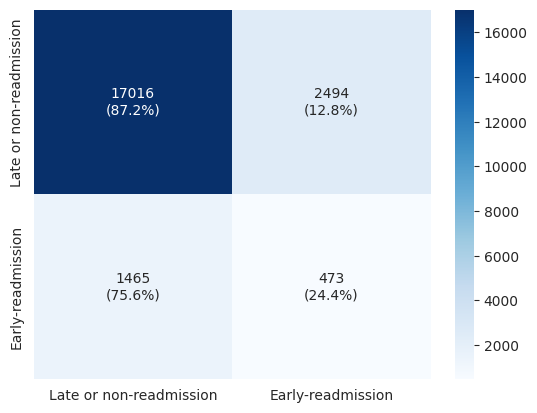

In [83]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

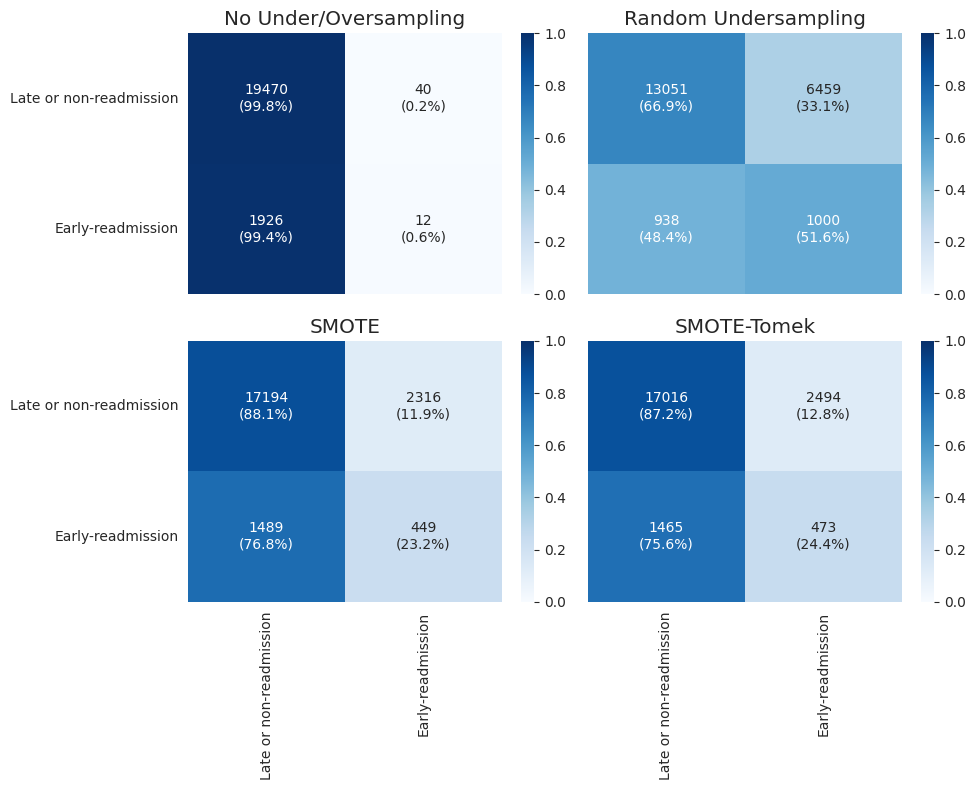

In [84]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [85]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

,Recall,Precision,F1-score,ROC-AUC,Accuracy
No Under/Oversampling,0.502071,0.570376,0.481999,0.502071,0.908336
Random Undersampling,0.592467,0.533507,0.496011,0.592467,0.655119
SMOTE,0.556487,0.541344,0.545658,0.556487,0.822594
SMOTE-Tomek,0.558117,0.540075,0.544328,0.558117,0.815414


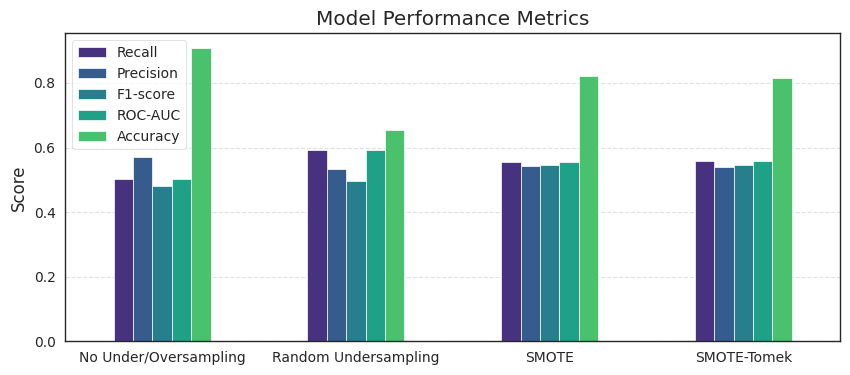

In [86]:
# Visualize all metrics in a bar plot, by coloring each method differently, using SeaBorn barplot and adding grids
sns.set_palette('viridis')
metrics_df.plot(kind='bar', figsize=(10, 4))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()